In [ ]:
# !pwd
import pandas as pd
import ast
import csv
import re
import numpy as np
from pathlib import Path
from functools import reduce
from datetime import timedelta, date
import datetime
import calendar

import math as m
import datetime as dt
import json
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.set_palette('ocean')
import nltk

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive



### Load, clean, explore data



In [ ]:
movies_df = pd.read_csv("/content/gdrive/MyDrive/movies_metadata_fixed_2.csv")

In [ ]:
movies_df.shape

(45463, 24)

In [ ]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45463 entries, 0 to 45462
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45463 non-null  bool   
 1   belongs_to_collection  4491 non-null   object 
 2   budget                 45463 non-null  int64  
 3   genres                 45463 non-null  object 
 4   homepage               7779 non-null   object 
 5   id                     45463 non-null  int64  
 6   imdb_id                45446 non-null  object 
 7   original_language      45452 non-null  object 
 8   original_title         45463 non-null  object 
 9   overview               44509 non-null  object 
 10  popularity             45463 non-null  float64
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [ ]:
# Use our knowledge of the industry/business of what is likely relevant (or might be relevant) to our analysis and drop unnecessary columns from the main movies_metadata file
# Note: original_title is the non-English title of foreign films, retaining title instead

movies_df.drop(columns=['adult', 'homepage', 'original_title', 'overview', 'poster_path', 'tagline', 'video'], inplace=True)
movies_df.head()

,belongs_to_collection,budget,genres,id,imdb_id,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",10/30/1995,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,7.7,5415
1,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",12/15/1995,262797249,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,6.9,2413
2,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228,en,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",12/22/1995,0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,6.5,92
3,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",12/22/1995,81452156,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,6.1,34
4,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,en,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/10/1995,76578911,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,5.7,173


In [ ]:
movies_df.duplicated(subset='id').sum()

30

In [ ]:
movies_df.drop_duplicates(subset='id', inplace=True)

In [ ]:
# Minor cleanup

# Remove tt from beginning of imdb_id
movies_df['imdb_id'] = movies_df['imdb_id'].str[2:]

# Ensure no whitespace messing up values
# movies_df['id'].str.strip() # REMOVED this bit because id is not string
movies_df['imdb_id'].str.strip()

# Rename 'belongs_to_collection column' and convert to 0 (not part of a series) or 1 (part of a series)
movies_df.rename(columns={'belongs_to_collection': 'series'}, inplace=True)
movies_df['series'].fillna(0, inplace=True)
movies_df['series'].loc[(movies_df['series']) != 0] = 1 # Fix copy issue if possible
movies_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,series,budget,genres,id,imdb_id,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count
0,1,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,0114709,en,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",10/30/1995,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,7.7,5415
1,0,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,0113497,en,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",12/15/1995,262797249,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,6.9,2413
2,1,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,0113228,en,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",12/22/1995,0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,6.5,92
3,0,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,0114885,en,3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",12/22/1995,81452156,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,6.1,34
4,1,0,"[{'id': 35, 'name': 'Comedy'}]",11862,0113041,en,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/10/1995,76578911,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,5.7,173


In [ ]:
movies_df.isnull().sum(axis=0)

series                    0
budget                    0
genres                    0
id                        0
imdb_id                  17
original_language        11
popularity                0
production_companies      0
production_countries      0
release_date             84
revenue                   0
runtime                 257
spoken_languages          0
status                   81
title                     0
vote_average              0
vote_count                0
dtype: int64

In [ ]:
# Calculate percentage of empty values and see what we should do

(movies_df[movies_df.isnull().any(axis=1)].shape[0]/movies_df.shape[0])*100

0.9442475733497678

In [ ]:
# Dropping records with missing values constitutes less than 1% of data
movies_df.dropna(how='any', inplace=True)

In [ ]:
movies_df.shape

(45004, 17)

In [ ]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45004 entries, 0 to 45462
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   series                45004 non-null  object 
 1   budget                45004 non-null  int64  
 2   genres                45004 non-null  object 
 3   id                    45004 non-null  int64  
 4   imdb_id               45004 non-null  object 
 5   original_language     45004 non-null  object 
 6   popularity            45004 non-null  float64
 7   production_companies  45004 non-null  object 
 8   production_countries  45004 non-null  object 
 9   release_date          45004 non-null  object 
 10  revenue               45004 non-null  int64  
 11  runtime               45004 non-null  float64
 12  spoken_languages      45004 non-null  object 
 13  status                45004 non-null  object 
 14  title                 45004 non-null  object 
 15  vote_average       

In [ ]:
# Ensure variable types are correct

movies_df['series'] = movies_df['series'].astype('int64')
movies_df['budget'] = movies_df['budget'].astype('float64')
movies_df['imdb_id'] = movies_df['imdb_id'].astype('int64')


In [ ]:
# Convert Date field to date format

movies_df['release_date_2']= pd.to_datetime(movies_df['release_date'])

In [ ]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45004 entries, 0 to 45462
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   series                45004 non-null  int64         
 1   budget                45004 non-null  float64       
 2   genres                45004 non-null  object        
 3   id                    45004 non-null  int64         
 4   imdb_id               45004 non-null  int64         
 5   original_language     45004 non-null  object        
 6   popularity            45004 non-null  float64       
 7   production_companies  45004 non-null  object        
 8   production_countries  45004 non-null  object        
 9   release_date          45004 non-null  object        
 10  revenue               45004 non-null  int64         
 11  runtime               45004 non-null  float64       
 12  spoken_languages      45004 non-null  object        
 13  status          

In [ ]:
movies_df.drop(columns=["release_date"], axis=1, inplace=True)
movies_df.rename(columns={"release_date_2": "release_date"}, inplace=True)
movies_df.head()

,series,budget,genres,id,imdb_id,original_language,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,release_date
0,1,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,114709,en,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,7.7,5415,1995-10-30
1,0,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,113497,en,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",262797249,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,6.9,2413,1995-12-15
2,1,0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,113228,en,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,6.5,92,1995-12-22
3,0,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,114885,en,3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",81452156,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,6.1,34,1995-12-22
4,1,0.0,"[{'id': 35, 'name': 'Comedy'}]",11862,113041,en,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",76578911,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,5.7,173,1995-02-10


In [ ]:
# Extract day, month, year released

movies_df['release_month'] = pd.DatetimeIndex(movies_df['release_date']).month
movies_df['release_day'] = pd.DatetimeIndex(movies_df['release_date']).day
movies_df['release_year'] = pd.DatetimeIndex(movies_df['release_date']).year

In [ ]:
# Check consistency

movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45004 entries, 0 to 45462
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   series                45004 non-null  int64         
 1   budget                45004 non-null  float64       
 2   genres                45004 non-null  object        
 3   id                    45004 non-null  int64         
 4   imdb_id               45004 non-null  int64         
 5   original_language     45004 non-null  object        
 6   popularity            45004 non-null  float64       
 7   production_companies  45004 non-null  object        
 8   production_countries  45004 non-null  object        
 9   revenue               45004 non-null  int64         
 10  runtime               45004 non-null  float64       
 11  spoken_languages      45004 non-null  object        
 12  status                45004 non-null  object        
 13  title           

In [ ]:
movies_df.describe()

,series,budget,id,imdb_id,popularity,revenue,runtime,vote_average,vote_count,release_month,release_day,release_year
count,45004.000000,4.500400e+04,45004.000000,4.500400e+04,45004.000000,4.500400e+04,45004.000000,45004.000000,45004.000000,45004.000000,45004.000000,45004.000000
mean,0.099436,4.264202e+06,107239.339481,9.886778e+05,2.946555,1.131894e+07,94.233246,5.638130,110.948138,6.461292,14.211781,1991.844925
std,0.299249,1.750605e+07,111656.287754,1.358373e+06,6.029073,6.464671e+07,38.309969,1.895844,493.675582,3.625460,9.278812,24.075687
min,0.000000,0.000000e+00,2.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,1.000000,1874.000000
25%,0.000000,0.000000e+00,26234.750000,8.273050e+04,0.399830,0.000000e+00,85.000000,5.000000,3.000000,3.000000,6.000000,1978.000000
50%,0.000000,0.000000e+00,59231.500000,2.819195e+05,1.143066,0.000000e+00,95.000000,6.000000,10.000000,7.000000,14.000000,2001.000000
75%,0.000000,0.000000e+00,154021.250000,1.533087e+06,3.736900,0.000000e+00,107.000000,6.800000,35.000000,10.000000,22.000000,2010.000000
max,1.000000,3.800000e+08,469172.000000,7.158814e+06,547.488298,2.787965e+09,1256.000000,10.000000,14075.000000,12.000000,31.000000,2020.000000


In [ ]:
# Reduce dataset to relevant observations - only want movies where:
# status = released (exclude movies that were cancelled, still in production, post-production, planning, or rumored)

movies_df = movies_df.loc[(movies_df['status']) == 'Released']
print(movies_df.shape)

# release_date > 1/1/1997 (exclude all movies made before 20 years ago)

movies_df = movies_df.loc[(movies_df['release_year']) >= 1997]
print(movies_df.shape)

(44650, 20)
(25626, 20)


In [ ]:
# Left with 25,626 observations. Now, interested to know how many of our budget, revenue, popularity and vote_average are non-zero.

print('non-zero budget:', (movies_df[movies_df['budget'] != 0].shape), (movies_df[movies_df['budget'] != 0].shape)[0]/movies_df.shape[0]*100,'%')
print('non-zero popularity:', (movies_df[movies_df['popularity'] != 0].shape), (movies_df[movies_df['popularity'] != 0].shape)[0]/movies_df.shape[0]*100,'%')
print('non-zero revenue:', (movies_df[movies_df['revenue'] != 0].shape), (movies_df[movies_df['revenue'] != 0].shape)[0]/movies_df.shape[0]*100,'%')
print('non-zero vote average:', (movies_df[movies_df['vote_average'] != 0].shape), (movies_df[movies_df['vote_average'] != 0].shape)[0]/movies_df.shape[0]*100,'%')

non-zero budget: (6325, 20) 24.681963630687584 %
non-zero popularity: (25626, 20) 100.0 %
non-zero revenue: (4985, 20) 19.452899399047844 %
non-zero vote average: (24310, 20) 94.86459065012097 %


Only 25% of our observations have a non-zero budget, and only 19% of our observations have non-zero revenue. 100% of our observations have a popularity score, and 95% have a vote average so we'll use popularity and/or vote average as our target variable.

In [ ]:
# Replace the 0 values for budget and revenue with NaN

movies_df['budget'] = movies_df['budget'].replace(0, np.nan)
movies_df['revenue'] = movies_df['revenue'].replace(0, np.nan)

In [ ]:
# Filter movies by production countries (US only)

movies_df = movies_df.loc[(movies_df['production_countries'].str.contains('United States of America', case=False))]
print(movies_df.shape)

(10811, 20)


In [ ]:
# Calculate a "Score" column based on the IMDB formula

m = movies_df['vote_count'].quantile(0.9)
C = movies_df['vote_average'].mean()
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C) 

In [ ]:
movies_df['score'] = movies_df.apply(weighted_rating, axis=1)

In [ ]:
# Drop "vote_count", "vote_average" colunms 
movies_df.drop(["vote_count", "vote_average"], axis=1, inplace=True)

In [ ]:
movies_df.shape

(10811, 19)

In [ ]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10811 entries, 759 to 45460
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   series                10811 non-null  int64         
 1   budget                4186 non-null   float64       
 2   genres                10811 non-null  object        
 3   id                    10811 non-null  int64         
 4   imdb_id               10811 non-null  int64         
 5   original_language     10811 non-null  object        
 6   popularity            10811 non-null  float64       
 7   production_companies  10811 non-null  object        
 8   production_countries  10811 non-null  object        
 9   revenue               3561 non-null   float64       
 10  runtime               10811 non-null  float64       
 11  spoken_languages      10811 non-null  object        
 12  status                10811 non-null  object        
 13  title         

Add ratings to movies df.

Note:

movies_df['id'] = credits_df['id'] = keywords_df['id'] = links_df['tmdbId']

ratings_df['movieId'] = links_df['movieId']

movies_df['imdb_id'] = links_df['imdbId']

In [ ]:
links = pd.read_csv('/content/gdrive/MyDrive//links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
# Note: there are 219 missing tmdbIds so will use imdbId code to populate ratings where tmdbId is missing if needed
links.isnull().sum(axis=0)

movieId      0
imdbId       0
tmdbId     219
dtype: int64

In [ ]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45843 entries, 0 to 45842
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  45843 non-null  int64  
 1   imdbId   45843 non-null  int64  
 2   tmdbId   45624 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.0 MB


In [ ]:
links['tmdbId'] = links['tmdbId'].astype('int', errors='ignore')

In [ ]:
movies2 = movies_df.merge(links, how='left', left_on='id', right_on='tmdbId')
movies2.head()

,series,budget,genres,id,imdb_id,original_language,popularity,production_companies,production_countries,revenue,...,status,title,release_date,release_month,release_day,release_year,score,movieId,imdbId,tmdbId
0,0,1000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",32872,118523,en,2.700061,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,...,Released,Til There Was You,1997-05-30,5,30,1997,5.656497,779,118523,32872.0
1,0,53000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",9054,119214,en,2.289647,"[{'name': 'Caravan Pictures', 'id': 175}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,...,Released,Gone Fishin',1997-05-30,5,30,1997,5.610749,870,119214,9054.0
2,0,60000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",11015,120004,en,7.699967,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",33956608.0,...,Released,The Relic,1997-01-10,1,10,1997,5.684052,879,120004,11015.0
3,0,NaN,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",56077,120271,en,0.978989,"[{'name': 'Kanzaman', 'id': 4169}, {'name': 'K...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,...,Released,Talk of Angels,1998-10-30,10,30,1998,5.670889,887,120271,56077.0
4,0,NaN,"[{'id': 18, 'name': 'Drama'}]",52855,118927,en,1.463219,"[{'name': 'New Line Cinema', 'id': 12}, {'name...","[{'iso_3166_1': 'US', 'name': 'United States o...",3028094.0,...,Released,Dangerous Ground,1997-02-12,2,12,1997,5.658687,981,118927,52855.0


In [ ]:
movies2.duplicated(subset='id').sum()

8

In [ ]:
movies2.drop_duplicates(subset='id', inplace=True)
movies2.shape

(10811, 22)

In [ ]:
ratings = pd.read_csv('/content/gdrive/MyDrive/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [ ]:
ratings.isnull().sum(axis=0)

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [ ]:
avgratings = ratings.groupby('movieId').agg({'rating': 'mean'}).reset_index()
avgratings.head()

,movieId,rating
0,1,3.888157
1,2,3.236953
2,3,3.175550
3,4,2.875713
4,5,3.079565


In [ ]:
movies3 = movies2.merge(avgratings, how='left', left_on='movieId', right_on='movieId')
movies3.head()

,series,budget,genres,id,imdb_id,original_language,popularity,production_companies,production_countries,revenue,...,title,release_date,release_month,release_day,release_year,score,movieId,imdbId,tmdbId,rating
0,0,1000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",32872,118523,en,2.700061,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,...,Til There Was You,1997-05-30,5,30,1997,5.656497,779,118523,32872.0,2.859066
1,0,53000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",9054,119214,en,2.289647,"[{'name': 'Caravan Pictures', 'id': 175}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,...,Gone Fishin',1997-05-30,5,30,1997,5.610749,870,119214,9054.0,2.249497
2,0,60000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",11015,120004,en,7.699967,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",33956608.0,...,The Relic,1997-01-10,1,10,1997,5.684052,879,120004,11015.0,2.815600
3,0,NaN,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",56077,120271,en,0.978989,"[{'name': 'Kanzaman', 'id': 4169}, {'name': 'K...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,...,Talk of Angels,1998-10-30,10,30,1998,5.670889,887,120271,56077.0,2.948980
4,0,NaN,"[{'id': 18, 'name': 'Drama'}]",52855,118927,en,1.463219,"[{'name': 'New Line Cinema', 'id': 12}, {'name...","[{'iso_3166_1': 'US', 'name': 'United States o...",3028094.0,...,Dangerous Ground,1997-02-12,2,12,1997,5.658687,981,118927,52855.0,2.640086


In [ ]:
movies3.shape

(10811, 23)

In [ ]:
# Drop unnecessary columns

movies3.drop(columns=['original_language', 'production_countries', 'imdbId', 'tmdbId'], inplace=True)
movies3.head()

,series,budget,genres,id,imdb_id,popularity,production_companies,revenue,runtime,spoken_languages,status,title,release_date,release_month,release_day,release_year,score,movieId,rating
0,0,1000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",32872,118523,2.700061,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",NaN,113.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Til There Was You,1997-05-30,5,30,1997,5.656497,779,2.859066
1,0,53000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",9054,119214,2.289647,"[{'name': 'Caravan Pictures', 'id': 175}, {'na...",NaN,94.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Gone Fishin',1997-05-30,5,30,1997,5.610749,870,2.249497
2,0,60000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",11015,120004,7.699967,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",33956608.0,110.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Relic,1997-01-10,1,10,1997,5.684052,879,2.815600
3,0,NaN,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",56077,120271,0.978989,"[{'name': 'Kanzaman', 'id': 4169}, {'name': 'K...",NaN,96.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Talk of Angels,1998-10-30,10,30,1998,5.670889,887,2.948980
4,0,NaN,"[{'id': 18, 'name': 'Drama'}]",52855,118927,1.463219,"[{'name': 'New Line Cinema', 'id': 12}, {'name...",3028094.0,95.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Dangerous Ground,1997-02-12,2,12,1997,5.658687,981,2.640086


In [ ]:
# Convert string of list to list
movies3["genres"] = movies3["genres"].apply(ast.literal_eval)
movies3["production_companies"] = movies3["production_companies"].apply(ast.literal_eval)
movies3['spoken_languages'] = movies3["spoken_languages"].apply(ast.literal_eval)

In [ ]:
# Genres conversion to dataframe from list of dictionary
movies3["genres_list"] = movies3["genres"].apply(lambda x: [x[i]['name'] for i in range(len(x))])
s = movies3['genres_list']
i = np.arange(len(movies3)).repeat(s.str.len())
df_genre = movies3.iloc[i, :-1].assign(**{'genres_list': np.concatenate(s.values)})[["id", "genres_list"]]
df_genre.head()

,id,genres_list
0,32872,Comedy
0,32872,Romance
1,9054,Comedy
1,9054,Family
2,11015,Horror


In [ ]:
df_genre.genres_list.value_counts().sort_values(ascending=False)

Drama              4283
Comedy             3520
Thriller           2569
Action             1886
Romance            1525
Horror             1487
Documentary        1294
Crime              1049
Adventure          1048
Family             1020
Science Fiction     973
Mystery             687
Fantasy             659
Animation           617
Music               365
TV Movie            305
History             245
War                 165
Western             105
Foreign              52
Name: genres_list, dtype: int64

In [ ]:
# Taking the genres dataframe and creating dummies
set_val = set(df_genre["genres_list"].values)
for i in set_val:    
    df_genre["genre_"+i] = np.where(df_genre["genres_list"] == i,1,0)
df_genre = df_genre.groupby("id").max()
df_genre.head()

,genres_list,genre_Horror,genre_Action,genre_Drama,genre_TV Movie,genre_Crime,genre_Music,genre_History,genre_Mystery,genre_War,...,genre_Fantasy,genre_Documentary,genre_Family,genre_Foreign,genre_Science Fiction,genre_Western,genre_Romance,genre_Animation,genre_Comedy,genre_Adventure
id,,,,,,,,,,,,,,,,,,,,,
12,Family,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
14,Drama,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,Music,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,Fantasy,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
24,Crime,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Merge with main movies dataframe

movies4 = pd.merge(movies3, df_genre, how='left', on='id')
movies4.head()

,series,budget,genres,id,imdb_id,popularity,production_companies,revenue,runtime,spoken_languages,...,genre_Fantasy,genre_Documentary,genre_Family,genre_Foreign,genre_Science Fiction,genre_Western,genre_Romance,genre_Animation,genre_Comedy,genre_Adventure
0,0,1000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",32872,118523,2.700061,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",NaN,113.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0,53000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",9054,119214,2.289647,"[{'name': 'Caravan Pictures', 'id': 175}, {'na...",NaN,94.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,60000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",11015,120004,7.699967,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",33956608.0,110.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,NaN,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",56077,120271,0.978989,"[{'name': 'Kanzaman', 'id': 4169}, {'name': 'K...",NaN,96.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,NaN,"[{'id': 18, 'name': 'Drama'}]",52855,118927,1.463219,"[{'name': 'New Line Cinema', 'id': 12}, {'name...",3028094.0,95.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
movies4.drop(columns=["genres_list_x","genres_list_y"], axis=1, inplace=True)
movies4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10811 entries, 0 to 10810
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   series                 10811 non-null  int64         
 1   budget                 4186 non-null   float64       
 2   genres                 10811 non-null  object        
 3   id                     10811 non-null  int64         
 4   imdb_id                10811 non-null  int64         
 5   popularity             10811 non-null  float64       
 6   production_companies   10811 non-null  object        
 7   revenue                3561 non-null   float64       
 8   runtime                10811 non-null  float64       
 9   spoken_languages       10811 non-null  object        
 10  status                 10811 non-null  object        
 11  title                  10811 non-null  object        
 12  release_date           10811 non-null  datetime64[ns]
 13  r

In [ ]:
movies4.dropna(subset=["genre_Fantasy"], inplace=True)
movies4.shape

(10697, 39)

In [ ]:
movies4["studio"] = movies4["production_companies"].apply(lambda x: [x[i]['name'] for i in range(len(x))])
s = movies4['studio']
i = np.arange(len(movies4)).repeat(s.str.len())
df_prod = movies4.iloc[i, :-1].assign(**{'studio': np.concatenate(s.values)})[["id", "studio"]]
df_prod['freq_studio'] = df_prod['studio'].map(df_prod['studio'].value_counts())
df_prod.head()

,id,studio,freq_studio
0,32872,Paramount Pictures,227
0,32872,Lakeshore Entertainment,50
1,9054,Caravan Pictures,10
1,9054,Hollywood Pictures,20
1,9054,Roger Birnbaum Productions,5


In [ ]:
df_prod.sort_values(['id','freq_studio'], ascending=[True, False], inplace=True)
df_prod.drop_duplicates(subset='id', keep='first', inplace=True)
df_prod.shape

(9033, 3)

In [ ]:
df_prod.head()

,id,studio,freq_studio
1373,12,Pixar Animation Studios,43
532,14,DreamWorks SKG,90
778,16,Canal+,33
1396,22,Walt Disney Pictures,177
1467,24,Miramax Films,101


In [ ]:
# Merge with main movies dataframe

movies5 = pd.merge(movies4, df_prod, how='left', on='id')
movies5.head()

,series,budget,genres,id,imdb_id,popularity,production_companies,revenue,runtime,spoken_languages,...,genre_Foreign,genre_Science Fiction,genre_Western,genre_Romance,genre_Animation,genre_Comedy,genre_Adventure,studio_x,studio_y,freq_studio
0,0,1000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",32872,118523,2.700061,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",NaN,113.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,"[Paramount Pictures, Lakeshore Entertainment]",Paramount Pictures,227.0
1,0,53000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",9054,119214,2.289647,"[{'name': 'Caravan Pictures', 'id': 175}, {'na...",NaN,94.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[Caravan Pictures, Hollywood Pictures, Roger B...",Hollywood Pictures,20.0
2,0,60000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",11015,120004,7.699967,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",33956608.0,110.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[Paramount Pictures, Universal Pictures, Toho-...",Universal Pictures,301.0
3,0,NaN,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",56077,120271,0.978989,"[{'name': 'Kanzaman', 'id': 4169}, {'name': 'K...",NaN,96.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[Kanzaman, Kan Zamia-a, Polaris Pictures]",Kanzaman,8.0
4,0,NaN,"[{'id': 18, 'name': 'Drama'}]",52855,118927,1.463219,"[{'name': 'New Line Cinema', 'id': 12}, {'name...",3028094.0,95.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[New Line Cinema, Jacaranda Films, Investec Me...",New Line Cinema,176.0


In [ ]:
movies5.drop(columns=["studio_x"], axis=1, inplace=True)
movies5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10697 entries, 0 to 10696
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   series                 10697 non-null  int64         
 1   budget                 4176 non-null   float64       
 2   genres                 10697 non-null  object        
 3   id                     10697 non-null  int64         
 4   imdb_id                10697 non-null  int64         
 5   popularity             10697 non-null  float64       
 6   production_companies   10697 non-null  object        
 7   revenue                3559 non-null   float64       
 8   runtime                10697 non-null  float64       
 9   spoken_languages       10697 non-null  object        
 10  status                 10697 non-null  object        
 11  title                  10697 non-null  object        
 12  release_date           10697 non-null  datetime64[ns]
 13  r

In [ ]:
movies5.dropna(subset=["studio_y"], inplace=True)
movies5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9033 entries, 0 to 10696
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   series                 9033 non-null   int64         
 1   budget                 3977 non-null   float64       
 2   genres                 9033 non-null   object        
 3   id                     9033 non-null   int64         
 4   imdb_id                9033 non-null   int64         
 5   popularity             9033 non-null   float64       
 6   production_companies   9033 non-null   object        
 7   revenue                3452 non-null   float64       
 8   runtime                9033 non-null   float64       
 9   spoken_languages       9033 non-null   object        
 10  status                 9033 non-null   object        
 11  title                  9033 non-null   object        
 12  release_date           9033 non-null   datetime64[ns]
 13  re

In [ ]:
# spoken_languages conversion to dataframe from list of dictionary

movies5["spoken_languages_list"] = movies5["spoken_languages"].apply(lambda x: [x[i]['name'] for i in range(len(x))])
s = movies5['spoken_languages_list']
i = np.arange(len(movies5)).repeat(s.str.len())
df_lang = movies5.iloc[i, :-1].assign(**{'spoken_languages_list': np.concatenate(s.values)})[["id", "spoken_languages_list"]]
df_lang.head()

,id,spoken_languages_list
0,32872,English
0,32872,Français
1,9054,English
2,11015,English
3,56077,English


In [ ]:
df_lang.spoken_languages_list.value_counts().sort_values(ascending=False).nlargest(10)

English      8759
Français      496
Español       474
Deutsch       344
Pусский       217
Italiano      203
日本語           115
Português      96
普通话            94
Polski         92
Name: spoken_languages_list, dtype: int64

In [ ]:
# Looking at the distribution of spoken languages, we can create two categories - English and Other
df_lang["spoken_languages_list_2"] = df_lang["spoken_languages_list"].apply(lambda x: "Other" if x not in ["English"] else x)

In [ ]:
# Taking the production companies dataframe and creating dummies

set_val = set(df_lang["spoken_languages_list_2"].values)
for i in set_val:    
    df_lang["spoken_lang_"+i] = np.where(df_lang["spoken_languages_list_2"] == i,1,0)
df_lang = df_lang.groupby("id").max()
df_lang.head()

,spoken_languages_list,spoken_languages_list_2,spoken_lang_English,spoken_lang_Other
id,,,,
12,English,English,1,0
14,English,English,1,0
16,English,English,1,0
22,English,English,1,0
24,日本語,Other,1,1


In [ ]:
# Merge with main movies dataframe

movies6 = pd.merge(movies5, df_lang, how='left', on='id')
movies6.head()

,series,budget,genres,id,imdb_id,popularity,production_companies,revenue,runtime,spoken_languages,...,genre_Animation,genre_Comedy,genre_Adventure,studio_y,freq_studio,spoken_languages_list_x,spoken_languages_list_y,spoken_languages_list_2,spoken_lang_English,spoken_lang_Other
0,0,1000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",32872,118523,2.700061,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",NaN,113.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",...,0.0,1.0,0.0,Paramount Pictures,227.0,"[English, Français]",Français,Other,1.0,1.0
1,0,53000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",9054,119214,2.289647,"[{'name': 'Caravan Pictures', 'id': 175}, {'na...",NaN,94.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,0.0,1.0,0.0,Hollywood Pictures,20.0,[English],English,English,1.0,0.0
2,0,60000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",11015,120004,7.699967,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",33956608.0,110.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,0.0,0.0,0.0,Universal Pictures,301.0,[English],English,English,1.0,0.0
3,0,NaN,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",56077,120271,0.978989,"[{'name': 'Kanzaman', 'id': 4169}, {'name': 'K...",NaN,96.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,0.0,0.0,0.0,Kanzaman,8.0,[English],English,English,1.0,0.0
4,0,NaN,"[{'id': 18, 'name': 'Drama'}]",52855,118927,1.463219,"[{'name': 'New Line Cinema', 'id': 12}, {'name...",3028094.0,95.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",...,0.0,0.0,0.0,New Line Cinema,176.0,"[English, Polski]",Polski,Other,1.0,1.0


In [ ]:
movies6.drop(columns=["spoken_languages_list_x","spoken_languages_list_y","spoken_languages_list_2"], axis=1, inplace=True)
movies6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9033 entries, 0 to 9032
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   series                 9033 non-null   int64         
 1   budget                 3977 non-null   float64       
 2   genres                 9033 non-null   object        
 3   id                     9033 non-null   int64         
 4   imdb_id                9033 non-null   int64         
 5   popularity             9033 non-null   float64       
 6   production_companies   9033 non-null   object        
 7   revenue                3452 non-null   float64       
 8   runtime                9033 non-null   float64       
 9   spoken_languages       9033 non-null   object        
 10  status                 9033 non-null   object        
 11  title                  9033 non-null   object        
 12  release_date           9033 non-null   datetime64[ns]
 13  rel

In [ ]:
movies6.dropna(subset=["spoken_lang_English"], inplace=True)
movies6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8889 entries, 0 to 9032
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   series                 8889 non-null   int64         
 1   budget                 3960 non-null   float64       
 2   genres                 8889 non-null   object        
 3   id                     8889 non-null   int64         
 4   imdb_id                8889 non-null   int64         
 5   popularity             8889 non-null   float64       
 6   production_companies   8889 non-null   object        
 7   revenue                3447 non-null   float64       
 8   runtime                8889 non-null   float64       
 9   spoken_languages       8889 non-null   object        
 10  status                 8889 non-null   object        
 11  title                  8889 non-null   object        
 12  release_date           8889 non-null   datetime64[ns]
 13  rel

In [ ]:
# Drop original genre and production company columns

movies6.drop(columns=['genres', 'production_companies','spoken_languages'], inplace=True)
movies6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8889 entries, 0 to 9032
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   series                 8889 non-null   int64         
 1   budget                 3960 non-null   float64       
 2   id                     8889 non-null   int64         
 3   imdb_id                8889 non-null   int64         
 4   popularity             8889 non-null   float64       
 5   revenue                3447 non-null   float64       
 6   runtime                8889 non-null   float64       
 7   status                 8889 non-null   object        
 8   title                  8889 non-null   object        
 9   release_date           8889 non-null   datetime64[ns]
 10  release_month          8889 non-null   int64         
 11  release_day            8889 non-null   int64         
 12  release_year           8889 non-null   int64         
 13  sco

In [ ]:
credits = pd.read_csv('/content/gdrive/MyDrive/credits.csv')

In [ ]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


Note: Gender is indicated by 1=Female 2=Male 0=unknown/missing

Order is indicated by 0=Lead 1=Supporting, etc.

In [ ]:
# Create tables of movies with all associated cast and crew members in separate dataframes

all_casts = []
all_crews = []

for i in range(credits.shape[0]):
    cast = eval(credits['cast'][i])
    for x in cast:
        x['id'] = credits['id'][i]
    crew = eval(credits['crew'][i])
    for x in crew:
        x['id'] = credits['id'][i]
    all_casts.extend(cast)
    all_crews.extend(crew)

cast = pd.DataFrame(all_casts)
crew = pd.DataFrame(all_crews)

In [ ]:
cast.gender.value_counts()

2    226713
0    223964
1    111797
Name: gender, dtype: int64

In [ ]:
crew.gender.value_counts()

0    272319
2    160872
1     31123
Name: gender, dtype: int64

In [ ]:
cast.head()

,cast_id,character,credit_id,gender,id,name,order,profile_path
0,14,Woody (voice),52fe4284c3a36847f8024f95,2,862,Tom Hanks,0,/pQFoyx7rp09CJTAb932F2g8Nlho.jpg
1,15,Buzz Lightyear (voice),52fe4284c3a36847f8024f99,2,862,Tim Allen,1,/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg
2,16,Mr. Potato Head (voice),52fe4284c3a36847f8024f9d,2,862,Don Rickles,2,/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg
3,17,Slinky Dog (voice),52fe4284c3a36847f8024fa1,2,862,Jim Varney,3,/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg
4,18,Rex (voice),52fe4284c3a36847f8024fa5,2,862,Wallace Shawn,4,/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg


In [ ]:
cast.drop(columns=['cast_id', 'character', 'credit_id', 'profile_path'], inplace=True)
cast.head()

,gender,id,name,order
0,2,862,Tom Hanks,0
1,2,862,Tim Allen,1
2,2,862,Don Rickles,2
3,2,862,Jim Varney,3
4,2,862,Wallace Shawn,4


In [ ]:
cast.name.value_counts().nlargest(35)

Bess Flowers          241
Christopher Lee       148
John Wayne            125
Samuel L. Jackson     123
Michael Caine         110
Gérard Depardieu      110
John Carradine        109
Donald Sutherland     109
Jackie Chan           108
Frank Welker          107
Robert De Niro        104
Danny Trejo           102
Steve Buscemi         101
Irving Bacon           98
John Goodman           97
Danny Glover           96
Christopher Walken     96
Dennis Hopper          94
Susan Sarandon         93
John Hurt              93
Eric Roberts           92
Harvey Keitel          91
Bruce Willis           91
Malcolm McDowell       90
Willem Dafoe           89
Anthony Quinn          88
Donald Pleasence       87
Keith David            87
Stellan Skarsgård      86
Whoopi Goldberg        85
Morgan Freeman         85
Robert Duvall          84
Max von Sydow          84
Charles Lane           84
James Franco           83
Name: name, dtype: int64

In [ ]:
# Too many cast options. Only keeping people with job functions of lead (0) or supporting (1)

lead = cast[cast['order'] == 0]
lead = lead.rename(columns={'name':'lead','gender':'gender_lead'})
lead.drop(columns=['order'], inplace=True)
lead['freq_lead'] = lead['lead'].map(lead['lead'].value_counts())
lead.head()

,gender_lead,id,lead,freq_lead
0,2,862,Tom Hanks,41
13,2,8844,Robin Williams,42
39,2,15602,Walter Matthau,24
46,1,31357,Whitney Houston,3
56,2,11862,Steve Martin,30


In [ ]:
print(lead.shape)
print(lead.duplicated().sum())

(36747, 4)
35


In [ ]:
lead.drop_duplicates(inplace=True)
lead.shape

(36712, 4)

In [ ]:
lead.lead.value_counts()

John Wayne          92
Jackie Chan         71
Nicolas Cage        55
Robert De Niro      53
Gérard Depardieu    50
                    ..
Madeleine Renaud     1
Lady Tabares         1
Gavin MacLeod        1
Jesse McCartney      1
Erika Eleniak        1
Name: lead, Length: 15049, dtype: int64

In [ ]:
lead.gender_lead.value_counts()

2    21300
1     8381
0     7031
Name: gender_lead, dtype: int64

In [ ]:
movies7 = pd.merge(movies6, lead, how='left', on='id')
movies7.head()

,series,budget,id,imdb_id,popularity,revenue,runtime,status,title,release_date,...,genre_Animation,genre_Comedy,genre_Adventure,studio_y,freq_studio,spoken_lang_English,spoken_lang_Other,gender_lead,lead,freq_lead
0,0,1000000.0,32872,118523,2.700061,NaN,113.0,Released,Til There Was You,1997-05-30,...,0.0,1.0,0.0,Paramount Pictures,227.0,1.0,1.0,1.0,Sarah Jessica Parker,9.0
1,0,53000000.0,9054,119214,2.289647,NaN,94.0,Released,Gone Fishin',1997-05-30,...,0.0,1.0,0.0,Hollywood Pictures,20.0,1.0,0.0,2.0,Joe Pesci,7.0
2,0,60000000.0,11015,120004,7.699967,33956608.0,110.0,Released,The Relic,1997-01-10,...,0.0,0.0,0.0,Universal Pictures,301.0,1.0,0.0,1.0,Penelope Ann Miller,3.0
3,0,NaN,56077,120271,0.978989,NaN,96.0,Released,Talk of Angels,1998-10-30,...,0.0,0.0,0.0,Kanzaman,8.0,1.0,0.0,1.0,Polly Walker,1.0
4,0,NaN,52855,118927,1.463219,3028094.0,95.0,Released,Dangerous Ground,1997-02-12,...,0.0,0.0,0.0,New Line Cinema,176.0,1.0,1.0,2.0,Ice Cube,16.0


In [ ]:
support = cast[cast['order'] == 1]
support = support.rename(columns={'name':'support','gender':'gender_support'})
support.drop(columns=['order'], inplace=True)
support['freq_support'] = support['support'].map(support['support'].value_counts())
support.head()

,gender_support,id,support,freq_support
1,2,862,Tim Allen,9
14,2,8844,Jonathan Hyde,1
40,2,15602,Jack Lemmon,10
47,1,31357,Angela Bassett,10
57,1,11862,Diane Keaton,25


In [ ]:
print(support.shape)
print(support.duplicated().sum())

(41589, 4)
38


In [ ]:
support.drop_duplicates(inplace=True)
support.shape

(41551, 4)

In [ ]:
support.support.value_counts()

Barbara Hale         34
Oliver Hardy         29
Lou Costello         26
Eric Roberts         25
Diane Keaton         25
                     ..
Caitlin Martin        1
Idina Menzel          1
David Grisman         1
Sally Stockwell       1
Nathalie Lissenko     1
Name: support, Length: 22008, dtype: int64

In [ ]:
support.gender_support.value_counts()

2    17929
1    13050
0    10572
Name: gender_support, dtype: int64

In [ ]:
movies8 = pd.merge(movies7, support, how='left', on='id')
movies8.head()

,series,budget,id,imdb_id,popularity,revenue,runtime,status,title,release_date,...,studio_y,freq_studio,spoken_lang_English,spoken_lang_Other,gender_lead,lead,freq_lead,gender_support,support,freq_support
0,0,1000000.0,32872,118523,2.700061,NaN,113.0,Released,Til There Was You,1997-05-30,...,Paramount Pictures,227.0,1.0,1.0,1.0,Sarah Jessica Parker,9.0,1.0,Jeanne Tripplehorn,2.0
1,0,53000000.0,9054,119214,2.289647,NaN,94.0,Released,Gone Fishin',1997-05-30,...,Hollywood Pictures,20.0,1.0,0.0,2.0,Joe Pesci,7.0,2.0,Danny Glover,20.0
2,0,60000000.0,11015,120004,7.699967,33956608.0,110.0,Released,The Relic,1997-01-10,...,Universal Pictures,301.0,1.0,0.0,1.0,Penelope Ann Miller,3.0,2.0,Tom Sizemore,8.0
3,0,NaN,56077,120271,0.978989,NaN,96.0,Released,Talk of Angels,1998-10-30,...,Kanzaman,8.0,1.0,0.0,1.0,Polly Walker,1.0,1.0,Frances McDormand,10.0
4,0,NaN,52855,118927,1.463219,3028094.0,95.0,Released,Dangerous Ground,1997-02-12,...,New Line Cinema,176.0,1.0,1.0,2.0,Ice Cube,16.0,1.0,Elizabeth Hurley,8.0


In [ ]:
movies8.shape

(8894, 46)

In [ ]:
movies8.drop_duplicates(subset=["id"],inplace=True)

In [ ]:
movies8.shape

(8889, 46)

In [ ]:
crew.head()

,credit_id,department,gender,id,job,name,profile_path
0,52fe4284c3a36847f8024f49,Directing,2,862,Director,John Lasseter,/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg
1,52fe4284c3a36847f8024f4f,Writing,2,862,Screenplay,Joss Whedon,/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg
2,52fe4284c3a36847f8024f55,Writing,2,862,Screenplay,Andrew Stanton,/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg
3,52fe4284c3a36847f8024f5b,Writing,2,862,Screenplay,Joel Cohen,/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg
4,52fe4284c3a36847f8024f61,Writing,0,862,Screenplay,Alec Sokolow,/v79vlRYi94BZUQnkkyznbGUZLjT.jpg


In [ ]:
crew.drop(columns=['credit_id', 'department', 'profile_path'], inplace=True)
crew.head()

,gender,id,job,name
0,2,862,Director,John Lasseter
1,2,862,Screenplay,Joss Whedon
2,2,862,Screenplay,Andrew Stanton
3,2,862,Screenplay,Joel Cohen
4,0,862,Screenplay,Alec Sokolow


In [ ]:
crew['job'].unique()

array(['Director', 'Screenplay', 'Producer', 'Executive Producer',
       'Editor', 'Art Direction', 'Foley Editor', 'Animation',
       'ADR Editor', 'Orchestrator', 'Color Timer', 'CG Painter',
       'Original Story', 'Post Production Supervisor', 'Sculptor',
       'Animation Director', 'Music', 'Layout', 'Music Editor',
       'Negative Cutter', 'Title Designer',
       'Supervising Technical Director', 'Songs', 'Supervising Animator',
       'Sound Designer', 'Production Supervisor',
       'Executive Music Producer', 'Visual Effects Supervisor',
       'Visual Effects', 'Lighting Supervisor', 'Character Designer',
       'Set Dresser', 'Editorial Manager', 'Assistant Editor',
       'Editorial Coordinator', 'Production Coordinator',
       'Unit Publicist', 'Sound Re-Recording Mixer',
       'Supervising Sound Editor', 'Sound Effects Editor',
       'Sound Design Assistant', 'Assistant Sound Editor',
       'Casting Consultant', 'ADR Voice Casting',
       'Original Music Compos

In [ ]:
# Too many crew options. Only keeping people with job functions of director or executive producer or producer or writer for now

director = crew[crew['job'] == 'Director']
director = director.rename(columns={'name':'director','gender':'gender_director'})
director.drop(columns=['job'], inplace=True)
director['freq_dir'] = director['director'].map(director['director'].value_counts())
director.head()

,gender_director,id,director,freq_dir
0,2,862,John Lasseter,10
109,2,8844,Joe Johnston,10
122,2,15602,Howard Deutch,11
126,2,31357,Forest Whitaker,4
141,2,11862,Charles Shyer,7


In [ ]:
print(director.shape)
print(director.duplicated().sum())

(49048, 4)
50


In [ ]:
director.drop_duplicates(inplace=True)
director.shape

(48998, 4)

In [ ]:
director.director.value_counts()

John Ford            68
Michael Curtiz       65
Werner Herzog        55
Alfred Hitchcock     53
Georges Méliès       51
                     ..
Jorge Dorado          1
Michael Rosenbaum     1
Lawrie Brewster       1
Connie Stevens        1
Daisy Asquith         1
Name: director, Length: 19740, dtype: int64

In [ ]:
director.gender_director.value_counts()

2    27553
0    19551
1     1894
Name: gender_director, dtype: int64

In [ ]:
director.shape

(48998, 4)

In [ ]:
director.sort_values(['id','freq_dir'], ascending=[True, False], inplace=True)
director.drop_duplicates(subset='id', keep='first', inplace=True)

In [ ]:
director.shape

(44545, 4)

In [ ]:
movies9 = pd.merge(movies8, director, how='left', on='id')
movies9.head()

,series,budget,id,imdb_id,popularity,revenue,runtime,status,title,release_date,...,spoken_lang_Other,gender_lead,lead,freq_lead,gender_support,support,freq_support,gender_director,director,freq_dir
0,0,1000000.0,32872,118523,2.700061,NaN,113.0,Released,Til There Was You,1997-05-30,...,1.0,1.0,Sarah Jessica Parker,9.0,1.0,Jeanne Tripplehorn,2.0,2.0,Scott Winant,1.0
1,0,53000000.0,9054,119214,2.289647,NaN,94.0,Released,Gone Fishin',1997-05-30,...,0.0,2.0,Joe Pesci,7.0,2.0,Danny Glover,20.0,2.0,Christopher Cain,11.0
2,0,60000000.0,11015,120004,7.699967,33956608.0,110.0,Released,The Relic,1997-01-10,...,0.0,1.0,Penelope Ann Miller,3.0,2.0,Tom Sizemore,8.0,2.0,Peter Hyams,18.0
3,0,NaN,56077,120271,0.978989,NaN,96.0,Released,Talk of Angels,1998-10-30,...,0.0,1.0,Polly Walker,1.0,1.0,Frances McDormand,10.0,2.0,Nick Hamm,6.0
4,0,NaN,52855,118927,1.463219,3028094.0,95.0,Released,Dangerous Ground,1997-02-12,...,1.0,2.0,Ice Cube,16.0,1.0,Elizabeth Hurley,8.0,0.0,Darrell James Roodt,7.0


In [ ]:
movies9.shape

(8889, 49)

In [ ]:
ep = crew[crew['job'] == 'Executive Producer']
ep = ep.rename(columns={'name':'execprod','gender':'gender_ep'})
ep.drop(columns=['job'], inplace=True)
ep['freq_ep'] = ep['execprod'].map(ep['execprod'].value_counts())
ep.head()

,gender_ep,id,execprod,freq_ep
6,0,862,Ed Catmull,2
8,2,862,Steve Jobs,1
106,2,8844,Larry J. Franco,3
115,2,8844,Ted Field,22
116,2,8844,Robert W. Cort,12


In [ ]:
print(ep.shape)
print(ep.duplicated().sum())

(18866, 4)
19


In [ ]:
ep.drop_duplicates(inplace=True)
ep.shape

(18847, 4)

In [ ]:
ep.execprod.value_counts()

Bob Weinstein           98
Harvey Weinstein        96
Hal B. Wallis           60
Roger Corman            58
Bruce Berman            57
                        ..
Jeff Katz                1
Jeff Kinney              1
Mads Peter Ole Olsen     1
Christine Alderson       1
Pirie Jones              1
Name: execprod, Length: 9939, dtype: int64

In [ ]:
ep.gender_ep.value_counts()

2    8787
0    8698
1    1362
Name: gender_ep, dtype: int64

In [ ]:
ep.shape

(18847, 4)

In [ ]:
ep.sort_values(['id','freq_ep'], ascending=[True, False], inplace=True)
ep.drop_duplicates(subset='id', keep='first', inplace=True)
ep.shape

(8370, 4)

In [ ]:
movies10 = pd.merge(movies9, ep, how='left', on='id')
movies10.head()

,series,budget,id,imdb_id,popularity,revenue,runtime,status,title,release_date,...,freq_lead,gender_support,support,freq_support,gender_director,director,freq_dir,gender_ep,execprod,freq_ep
0,0,1000000.0,32872,118523,2.700061,NaN,113.0,Released,Til There Was You,1997-05-30,...,9.0,1.0,Jeanne Tripplehorn,2.0,2.0,Scott Winant,1.0,NaN,NaN,NaN
1,0,53000000.0,9054,119214,2.289647,NaN,94.0,Released,Gone Fishin',1997-05-30,...,7.0,2.0,Danny Glover,20.0,2.0,Christopher Cain,11.0,NaN,NaN,NaN
2,0,60000000.0,11015,120004,7.699967,33956608.0,110.0,Released,The Relic,1997-01-10,...,3.0,2.0,Tom Sizemore,8.0,2.0,Peter Hyams,18.0,2.0,Mark Gordon,9.0
3,0,NaN,56077,120271,0.978989,NaN,96.0,Released,Talk of Angels,1998-10-30,...,1.0,1.0,Frances McDormand,10.0,2.0,Nick Hamm,6.0,NaN,NaN,NaN
4,0,NaN,52855,118927,1.463219,3028094.0,95.0,Released,Dangerous Ground,1997-02-12,...,16.0,1.0,Elizabeth Hurley,8.0,0.0,Darrell James Roodt,7.0,NaN,NaN,NaN


In [ ]:
movies10.shape

(8889, 52)

In [ ]:
prod = crew[crew['job'] == 'Producer']
prod = prod.rename(columns={'name':'producer','gender':'gender_producer'})
prod.drop(columns=['job'], inplace=True)
prod['freq_producer'] = prod['producer'].map(prod['producer'].value_counts())
prod.head()

,gender_producer,id,producer,freq_producer
5,1,862,Bonnie Arnold,4
7,2,862,Ralph Guggenheim,1
114,2,8844,Scott Kroopf,17
119,2,8844,William Teitler,7
128,0,31357,Ronald Bass,4


In [ ]:
print(prod.shape)
print(prod.duplicated().sum())

(43555, 4)
65


In [ ]:
prod.drop_duplicates(inplace=True)
prod.shape

(43490, 4)

In [ ]:
prod.producer.value_counts()

Darryl F. Zanuck    75
Walt Disney         73
Hal B. Wallis       70
Brian Grazer        67
Scott Rudin         62
                    ..
Oleg Kokhan          1
Elma Tataragić       1
William Girard       1
Philippe Caland      1
Hamid Nematollah     1
Name: producer, Length: 20017, dtype: int64

In [ ]:
prod.gender_producer.value_counts()

2    20308
0    20219
1     2963
Name: gender_producer, dtype: int64

In [ ]:
prod.shape

(43490, 4)

In [ ]:
prod.sort_values(['id','freq_producer'], ascending=[True, False], inplace=True)
prod.drop_duplicates(subset='id', keep='first', inplace=True)

In [ ]:
prod.shape

(21986, 4)

In [ ]:
movies11 = pd.merge(movies10, prod, how='left', on='id')
movies11.head()

,series,budget,id,imdb_id,popularity,revenue,runtime,status,title,release_date,...,freq_support,gender_director,director,freq_dir,gender_ep,execprod,freq_ep,gender_producer,producer,freq_producer
0,0,1000000.0,32872,118523,2.700061,NaN,113.0,Released,Til There Was You,1997-05-30,...,2.0,2.0,Scott Winant,1.0,NaN,NaN,NaN,1.0,Penney Finkelman Cox,4.0
1,0,53000000.0,9054,119214,2.289647,NaN,94.0,Released,Gone Fishin',1997-05-30,...,20.0,2.0,Christopher Cain,11.0,NaN,NaN,NaN,2.0,Roger Birnbaum,36.0
2,0,60000000.0,11015,120004,7.699967,33956608.0,110.0,Released,The Relic,1997-01-10,...,8.0,2.0,Peter Hyams,18.0,2.0,Mark Gordon,9.0,1.0,Gale Anne Hurd,26.0
3,0,NaN,56077,120271,0.978989,NaN,96.0,Released,Talk of Angels,1998-10-30,...,10.0,2.0,Nick Hamm,6.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,NaN,52855,118927,1.463219,3028094.0,95.0,Released,Dangerous Ground,1997-02-12,...,8.0,0.0,Darrell James Roodt,7.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
movies11.shape

(8889, 55)

In [ ]:
scnply = crew[crew['job'] == 'Screenplay']
scnply = scnply.rename(columns={'name':'writer','gender':'gender_scnply'})
scnply.drop(columns=['job'], inplace=True)
scnply['freq_scnply'] = scnply['writer'].map(scnply['writer'].value_counts())
scnply.head()

,gender_scnply,id,writer,freq_scnply
1,2,862,Joss Whedon,7
2,2,862,Andrew Stanton,8
3,2,862,Joel Cohen,6
4,0,862,Alec Sokolow,6
107,2,8844,Jonathan Hensleigh,7


In [ ]:
print(scnply.shape)
print(scnply.duplicated().sum())

(25163, 4)
20


In [ ]:
scnply.drop_duplicates(inplace=True)
scnply.shape

(25143, 4)

In [ ]:
scnply.writer.value_counts()

Ben Hecht             35
Woody Allen           33
Ernesto Gastaldi      30
Dudley Nichols        29
Nunnally Johnson      29
                      ..
Ripley Highsmith       1
Matt Roe               1
Sarett Tobias          1
John Jacoby            1
Jeffrey Goldenberg     1
Name: writer, Length: 12817, dtype: int64

In [ ]:
scnply.gender_scnply.value_counts()

2    12900
0    10910
1     1333
Name: gender_scnply, dtype: int64

In [ ]:
scnply.shape

(25143, 4)

In [ ]:
scnply.sort_values(['id','freq_scnply'], ascending=[True, False], inplace=True)
scnply.drop_duplicates(subset='id', keep='first', inplace=True)
scnply.shape

(15713, 4)

In [ ]:
movies12 = pd.merge(movies11, scnply, how='left', on='id')
movies12.head()

,series,budget,id,imdb_id,popularity,revenue,runtime,status,title,release_date,...,freq_dir,gender_ep,execprod,freq_ep,gender_producer,producer,freq_producer,gender_scnply,writer,freq_scnply
0,0,1000000.0,32872,118523,2.700061,NaN,113.0,Released,Til There Was You,1997-05-30,...,1.0,NaN,NaN,NaN,1.0,Penney Finkelman Cox,4.0,NaN,NaN,NaN
1,0,53000000.0,9054,119214,2.289647,NaN,94.0,Released,Gone Fishin',1997-05-30,...,11.0,NaN,NaN,NaN,2.0,Roger Birnbaum,36.0,NaN,NaN,NaN
2,0,60000000.0,11015,120004,7.699967,33956608.0,110.0,Released,The Relic,1997-01-10,...,18.0,2.0,Mark Gordon,9.0,1.0,Gale Anne Hurd,26.0,1.0,Amy Holden Jones,5.0
3,0,NaN,56077,120271,0.978989,NaN,96.0,Released,Talk of Angels,1998-10-30,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Frank McGuinness,2.0
4,0,NaN,52855,118927,1.463219,3028094.0,95.0,Released,Dangerous Ground,1997-02-12,...,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
movies12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8889 entries, 0 to 8888
Data columns (total 58 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   series                 8889 non-null   int64         
 1   budget                 3960 non-null   float64       
 2   id                     8889 non-null   int64         
 3   imdb_id                8889 non-null   int64         
 4   popularity             8889 non-null   float64       
 5   revenue                3447 non-null   float64       
 6   runtime                8889 non-null   float64       
 7   status                 8889 non-null   object        
 8   title                  8889 non-null   object        
 9   release_date           8889 non-null   datetime64[ns]
 10  release_month          8889 non-null   int64         
 11  release_day            8889 non-null   int64         
 12  release_year           8889 non-null   int64         
 13  sco

In [ ]:
# Add keywords

keywords = pd.read_csv('/content/gdrive/MyDrive/keywords.csv')
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [ ]:
print(keywords.shape)
print(keywords.duplicated().sum())

(46419, 2)
987


In [ ]:
keywords.drop_duplicates(inplace=True)
keywords.shape

(45432, 2)

In [ ]:
kwlist = []

for i in range(keywords.shape[0]):
    keyw = eval(keywords['keywords'].iloc[i])
    for each in keyw:
        each['id'] = keywords['id'].iloc[i]
    kwlist.extend(keyw)
k = pd.DataFrame(kwlist)

k = k.rename(columns={'name':'keyword'})
#k['tmp'] = 1
k.head()

,id,keyword
0,862,jealousy
1,862,toy
2,862,boy
3,862,friendship
4,862,friends


In [ ]:
k = k.groupby('id')['keyword'].apply(', '.join).reset_index()
k.head()

,id,keyword
0,2,"underdog, prison, factory worker, prisoner, he..."
1,3,"salesclerk, helsinki, garbage, independent film"
2,5,"hotel, new year's eve, witch, bet, hotel room,..."
3,6,"chicago, drug dealer, boxing match, escape, on..."
4,11,"android, galaxy, hermit, death star, lightsabe..."


In [ ]:
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(tokenizer=word_tokenize,ngram_range=(1,2), binary=True, max_features=30,stop_words='english')
TFIDF=vect.fit_transform(k['keyword'])

In [ ]:
print(vect.get_feature_names())

[',', ', based', ', independent', ', murder', ', woman', 'based', 'comedy', 'director', 'family', 'female', 'film', 'film ,', 'independent', 'independent film', 'love', 'love ,', 'movie', 'murder', 'murder ,', 'musical', 'new', 'novel', 'nudity', 'nudity ,', 'relationship', 'relationship ,', 'sex', 'war', 'woman', 'woman director']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
movies13 = pd.merge(movies12, k, how='left', on='id')
movies13.head()

,series,budget,id,imdb_id,popularity,revenue,runtime,status,title,release_date,...,gender_ep,execprod,freq_ep,gender_producer,producer,freq_producer,gender_scnply,writer,freq_scnply,keyword
0,0,1000000.0,32872,118523,2.700061,NaN,113.0,Released,Til There Was You,1997-05-30,...,NaN,NaN,NaN,1.0,Penney Finkelman Cox,4.0,NaN,NaN,NaN,"poem, father son relationship, support group, ..."
1,0,53000000.0,9054,119214,2.289647,NaN,94.0,Released,Gone Fishin',1997-05-30,...,NaN,NaN,NaN,2.0,Roger Birnbaum,36.0,NaN,NaN,NaN,"sea, boat, fishing, rogue"
2,0,60000000.0,11015,120004,7.699967,33956608.0,110.0,Released,The Relic,1997-01-10,...,2.0,Mark Gordon,9.0,1.0,Gale Anne Hurd,26.0,1.0,Amy Holden Jones,5.0,"chicago, based on novel, monster, museum, pile..."
3,0,NaN,56077,120271,0.978989,NaN,96.0,Released,Talk of Angels,1998-10-30,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Frank McGuinness,2.0,independent film
4,0,NaN,52855,118927,1.463219,3028094.0,95.0,Released,Dangerous Ground,1997-02-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,independent film


In [ ]:
movies13.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8889 entries, 0 to 8888
Data columns (total 59 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   series                 8889 non-null   int64         
 1   budget                 3960 non-null   float64       
 2   id                     8889 non-null   int64         
 3   imdb_id                8889 non-null   int64         
 4   popularity             8889 non-null   float64       
 5   revenue                3447 non-null   float64       
 6   runtime                8889 non-null   float64       
 7   status                 8889 non-null   object        
 8   title                  8889 non-null   object        
 9   release_date           8889 non-null   datetime64[ns]
 10  release_month          8889 non-null   int64         
 11  release_day            8889 non-null   int64         
 12  release_year           8889 non-null   int64         
 13  sco

In [ ]:
# Missing a lot of info for executive producers, producers, and writers (including gender) - drop those categories

cols2drop = [49, 50, 51, 52, 53, 54, 55, 56, 57]
movies14 = movies13.iloc[:, [j for j, c in enumerate(movies13.columns) if j not in cols2drop]]
movies14.head()

,series,budget,id,imdb_id,popularity,revenue,runtime,status,title,release_date,...,gender_lead,lead,freq_lead,gender_support,support,freq_support,gender_director,director,freq_dir,keyword
0,0,1000000.0,32872,118523,2.700061,NaN,113.0,Released,Til There Was You,1997-05-30,...,1.0,Sarah Jessica Parker,9.0,1.0,Jeanne Tripplehorn,2.0,2.0,Scott Winant,1.0,"poem, father son relationship, support group, ..."
1,0,53000000.0,9054,119214,2.289647,NaN,94.0,Released,Gone Fishin',1997-05-30,...,2.0,Joe Pesci,7.0,2.0,Danny Glover,20.0,2.0,Christopher Cain,11.0,"sea, boat, fishing, rogue"
2,0,60000000.0,11015,120004,7.699967,33956608.0,110.0,Released,The Relic,1997-01-10,...,1.0,Penelope Ann Miller,3.0,2.0,Tom Sizemore,8.0,2.0,Peter Hyams,18.0,"chicago, based on novel, monster, museum, pile..."
3,0,NaN,56077,120271,0.978989,NaN,96.0,Released,Talk of Angels,1998-10-30,...,1.0,Polly Walker,1.0,1.0,Frances McDormand,10.0,2.0,Nick Hamm,6.0,independent film
4,0,NaN,52855,118927,1.463219,3028094.0,95.0,Released,Dangerous Ground,1997-02-12,...,2.0,Ice Cube,16.0,1.0,Elizabeth Hurley,8.0,0.0,Darrell James Roodt,7.0,independent film


In [ ]:
# Convert gender column for remaining cast/crew columns to isFemale

movies14.rename(columns={'gender_lead': 'isFemale_lead', 'gender_support': 'isFemale_support', 'gender_director': 'isFemale_director'}, inplace=True)

# Replace the 0 values for gender with NaN

movies14['isFemale_lead'] = movies14['isFemale_lead'].replace(0, np.nan)
movies14['isFemale_support'] = movies14['isFemale_support'].replace(0, np.nan)
movies14['isFemale_director'] = movies14['isFemale_director'].replace(0, np.nan)

# Replace the 2 values for gender with 0

movies14['isFemale_lead'] = movies14['isFemale_lead'].replace(2, 0)
movies14['isFemale_support'] = movies14['isFemale_support'].replace(2, 0)
movies14['isFemale_director'] = movies14['isFemale_director'].replace(2, 0)

movies14.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

,series,budget,id,imdb_id,popularity,revenue,runtime,status,title,release_date,...,isFemale_lead,lead,freq_lead,isFemale_support,support,freq_support,isFemale_director,director,freq_dir,keyword
0,0,1000000.0,32872,118523,2.700061,NaN,113.0,Released,Til There Was You,1997-05-30,...,1.0,Sarah Jessica Parker,9.0,1.0,Jeanne Tripplehorn,2.0,0.0,Scott Winant,1.0,"poem, father son relationship, support group, ..."
1,0,53000000.0,9054,119214,2.289647,NaN,94.0,Released,Gone Fishin',1997-05-30,...,0.0,Joe Pesci,7.0,0.0,Danny Glover,20.0,0.0,Christopher Cain,11.0,"sea, boat, fishing, rogue"
2,0,60000000.0,11015,120004,7.699967,33956608.0,110.0,Released,The Relic,1997-01-10,...,1.0,Penelope Ann Miller,3.0,0.0,Tom Sizemore,8.0,0.0,Peter Hyams,18.0,"chicago, based on novel, monster, museum, pile..."
3,0,NaN,56077,120271,0.978989,NaN,96.0,Released,Talk of Angels,1998-10-30,...,1.0,Polly Walker,1.0,1.0,Frances McDormand,10.0,0.0,Nick Hamm,6.0,independent film
4,0,NaN,52855,118927,1.463219,3028094.0,95.0,Released,Dangerous Ground,1997-02-12,...,0.0,Ice Cube,16.0,1.0,Elizabeth Hurley,8.0,NaN,Darrell James Roodt,7.0,independent film


In [ ]:
# Drop unnecessary columns

movies14.drop(columns=['status', 'movieId'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
movies14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8889 entries, 0 to 8888
Data columns (total 48 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   series                 8889 non-null   int64         
 1   budget                 3960 non-null   float64       
 2   id                     8889 non-null   int64         
 3   imdb_id                8889 non-null   int64         
 4   popularity             8889 non-null   float64       
 5   revenue                3447 non-null   float64       
 6   runtime                8889 non-null   float64       
 7   title                  8889 non-null   object        
 8   release_date           8889 non-null   datetime64[ns]
 9   release_month          8889 non-null   int64         
 10  release_day            8889 non-null   int64         
 11  release_year           8889 non-null   int64         
 12  score                  8889 non-null   float64       
 13  rat

In [ ]:
movies14.duplicated(subset='id').sum()

0

In [ ]:
# Bucketize lead, support, and director

movies14['leadAppearances'] = pd.cut(movies14['freq_lead'], bins=np.linspace(0,75,6))
movies14['supportAppearances'] = pd.cut(movies14['freq_support'], bins=np.linspace(0,25,6))
movies14['dirAppearances'] = pd.cut(movies14['freq_dir'], bins=np.linspace(0,55,5))
movies14['studioAppearances'] = pd.cut(movies14['freq_studio'], bins=np.linspace(0,304,7))

movies14.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,series,budget,id,imdb_id,popularity,revenue,runtime,title,release_date,release_month,...,support,freq_support,isFemale_director,director,freq_dir,keyword,leadAppearances,supportAppearances,dirAppearances,studioAppearances
0,0,1000000.0,32872,118523,2.700061,NaN,113.0,Til There Was You,1997-05-30,5,...,Jeanne Tripplehorn,2.0,0.0,Scott Winant,1.0,"poem, father son relationship, support group, ...","(0.0, 15.0]","(0.0, 5.0]","(0.0, 13.75]","(202.667, 253.333]"
1,0,53000000.0,9054,119214,2.289647,NaN,94.0,Gone Fishin',1997-05-30,5,...,Danny Glover,20.0,0.0,Christopher Cain,11.0,"sea, boat, fishing, rogue","(0.0, 15.0]","(15.0, 20.0]","(0.0, 13.75]","(0.0, 50.667]"
2,0,60000000.0,11015,120004,7.699967,33956608.0,110.0,The Relic,1997-01-10,1,...,Tom Sizemore,8.0,0.0,Peter Hyams,18.0,"chicago, based on novel, monster, museum, pile...","(0.0, 15.0]","(5.0, 10.0]","(13.75, 27.5]","(253.333, 304.0]"
3,0,NaN,56077,120271,0.978989,NaN,96.0,Talk of Angels,1998-10-30,10,...,Frances McDormand,10.0,0.0,Nick Hamm,6.0,independent film,"(0.0, 15.0]","(5.0, 10.0]","(0.0, 13.75]","(0.0, 50.667]"
4,0,NaN,52855,118927,1.463219,3028094.0,95.0,Dangerous Ground,1997-02-12,2,...,Elizabeth Hurley,8.0,NaN,Darrell James Roodt,7.0,independent film,"(15.0, 30.0]","(5.0, 10.0]","(0.0, 13.75]","(152.0, 202.667]"


In [ ]:
movies14['leadAppearances'].unique()

[(0.0, 15.0], (15.0, 30.0], NaN, (30.0, 45.0], (45.0, 60.0], (60.0, 75.0]]
Categories (5, interval[float64, right]): [(0.0, 15.0] < (15.0, 30.0] < (30.0, 45.0] <
                                           (45.0, 60.0] < (60.0, 75.0]]

In [ ]:
movies14['supportAppearances'].unique()

[(0.0, 5.0], (15.0, 20.0], (5.0, 10.0], (10.0, 15.0], (20.0, 25.0], NaN]
Categories (5, interval[float64, right]): [(0.0, 5.0] < (5.0, 10.0] < (10.0, 15.0] < (15.0, 20.0] <
                                           (20.0, 25.0]]

In [ ]:
movies14['dirAppearances'].unique()

[(0.0, 13.75], (13.75, 27.5], (27.5, 41.25], (41.25, 55.0], NaN]
Categories (4, interval[float64, right]): [(0.0, 13.75] < (13.75, 27.5] < (27.5, 41.25] <
                                           (41.25, 55.0]]

In [ ]:
movies14['studioAppearances'].unique()

[(202.667, 253.333], (0.0, 50.667], (253.333, 304.0], (152.0, 202.667], (101.333, 152.0], (50.667, 101.333]]
Categories (6, interval[float64, right]): [(0.0, 50.667] < (50.667, 101.333] < (101.333, 152.0] <
                                           (152.0, 202.667] < (202.667, 253.333] < (253.333, 304.0]]

In [ ]:
movies_final_w_dummies = pd.concat([movies14, pd.get_dummies(movies14['leadAppearances'])], axis=1).drop(['freq_lead'], axis=1)
col = movies_final_w_dummies.columns # 55 col is (60-75] etc.
movies_final_w_dummies.rename(columns={col[51]:'lead_5Quintile', col[52]:'lead_4Quintile', col[53]:'lead_3Quintile', col[54]:'lead_2Quintile', col[55]:'lead_1Quintile'}, inplace=True)
movies_final_w_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8889 entries, 0 to 8888
Data columns (total 56 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   series                 8889 non-null   int64         
 1   budget                 3960 non-null   float64       
 2   id                     8889 non-null   int64         
 3   imdb_id                8889 non-null   int64         
 4   popularity             8889 non-null   float64       
 5   revenue                3447 non-null   float64       
 6   runtime                8889 non-null   float64       
 7   title                  8889 non-null   object        
 8   release_date           8889 non-null   datetime64[ns]
 9   release_month          8889 non-null   int64         
 10  release_day            8889 non-null   int64         
 11  release_year           8889 non-null   int64         
 12  score                  8889 non-null   float64       
 13  rat

In [ ]:
movies_final_w_dummies = pd.concat([movies_final_w_dummies, pd.get_dummies(movies14['supportAppearances'])], axis=1).drop(['freq_support'], axis=1)
col = movies_final_w_dummies.columns
movies_final_w_dummies.rename(columns={col[55]:'support_5Quintile', col[56]:'support_4Quintile', col[57]:'support_3Quintile', col[58]:'support_2Quintile', col[59]:'support_1Quintile'}, inplace=True)
movies_final_w_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8889 entries, 0 to 8888
Data columns (total 60 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   series                 8889 non-null   int64         
 1   budget                 3960 non-null   float64       
 2   id                     8889 non-null   int64         
 3   imdb_id                8889 non-null   int64         
 4   popularity             8889 non-null   float64       
 5   revenue                3447 non-null   float64       
 6   runtime                8889 non-null   float64       
 7   title                  8889 non-null   object        
 8   release_date           8889 non-null   datetime64[ns]
 9   release_month          8889 non-null   int64         
 10  release_day            8889 non-null   int64         
 11  release_year           8889 non-null   int64         
 12  score                  8889 non-null   float64       
 13  rat

In [ ]:
movies_final_w_dummies = pd.concat([movies_final_w_dummies, pd.get_dummies(movies14['dirAppearances'])], axis=1).drop(['freq_dir'], axis=1)
col = movies_final_w_dummies.columns
movies_final_w_dummies.rename(columns={col[59]:'dir_4Quartile', col[60]:'dir_3Quartile', col[61]:'dir_2Quartile', col[62]:'dir_1Quintile'}, inplace=True)
movies_final_w_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8889 entries, 0 to 8888
Data columns (total 63 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   series                 8889 non-null   int64         
 1   budget                 3960 non-null   float64       
 2   id                     8889 non-null   int64         
 3   imdb_id                8889 non-null   int64         
 4   popularity             8889 non-null   float64       
 5   revenue                3447 non-null   float64       
 6   runtime                8889 non-null   float64       
 7   title                  8889 non-null   object        
 8   release_date           8889 non-null   datetime64[ns]
 9   release_month          8889 non-null   int64         
 10  release_day            8889 non-null   int64         
 11  release_year           8889 non-null   int64         
 12  score                  8889 non-null   float64       
 13  rat

In [ ]:
movies_final_w_dummies = pd.concat([movies_final_w_dummies, pd.get_dummies(movies14['studioAppearances'])], axis=1).drop(['freq_studio'], axis=1)
col = movies_final_w_dummies.columns
movies_final_w_dummies.rename(columns={col[62]:'studio_6Quartile', col[63]:'studio_5Quartile', col[64]:'studio_4Quartile', col[65]:'studio_3Quartile', col[66]:'studio_2Quartile', col[67]:'studio_1Quartile'}, inplace=True)
movies_final_w_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8889 entries, 0 to 8888
Data columns (total 68 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   series                 8889 non-null   int64         
 1   budget                 3960 non-null   float64       
 2   id                     8889 non-null   int64         
 3   imdb_id                8889 non-null   int64         
 4   popularity             8889 non-null   float64       
 5   revenue                3447 non-null   float64       
 6   runtime                8889 non-null   float64       
 7   title                  8889 non-null   object        
 8   release_date           8889 non-null   datetime64[ns]
 9   release_month          8889 non-null   int64         
 10  release_day            8889 non-null   int64         
 11  release_year           8889 non-null   int64         
 12  score                  8889 non-null   float64       
 13  rat

In [ ]:
movies_final_w_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8889 entries, 0 to 8888
Data columns (total 68 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   series                 8889 non-null   int64         
 1   budget                 3960 non-null   float64       
 2   id                     8889 non-null   int64         
 3   imdb_id                8889 non-null   int64         
 4   popularity             8889 non-null   float64       
 5   revenue                3447 non-null   float64       
 6   runtime                8889 non-null   float64       
 7   title                  8889 non-null   object        
 8   release_date           8889 non-null   datetime64[ns]
 9   release_month          8889 non-null   int64         
 10  release_day            8889 non-null   int64         
 11  release_year           8889 non-null   int64         
 12  score                  8889 non-null   float64       
 13  rat

In [ ]:
movies_final_w_dummies.drop(columns=['dirAppearances','supportAppearances','leadAppearances','studioAppearances'], axis=1, inplace=True)

In [ ]:
movies_final_w_dummies.shape

(8889, 64)

In [ ]:
# movies14.to_csv("/content/gdrive/MyDrive/data_new.csv", index=False)
# movies_final_w_dummies.to_csv("/content/gdrive/MyDrive/data_w_dummies_final.csv", index=False)

Note: after outputting the "data_w_dummies_final.csv" file in the code above, we created a second data file to test our models by using Excel/OpenRefine to quickly create a modified dataset that converted the dummy variables for the director, lead, support, and studio quartiles/quintiles into ordinal features. This allowed us to reduce the number of overall features from 67 to 47. This second method also proved to be more successful with our models, and is the dataset "data_w_dummies_final_2.csv" that we load in the next cell.



# Descriptive Analysis



In [ ]:
movies_final = pd.read_csv("/content/gdrive/MyDrive/data_w_dummies_final_2.csv")
movies_df = pd.read_csv("/content/gdrive/MyDrive/movies_metadata_fixed_2.csv")

In [ ]:
test = movies_final[['popularity','budget','revenue']]
test.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
test['return'] = test['revenue']/test['budget']
test['popularity_bin'] = pd.cut(test['popularity'],bins=np.linspace(0,600,5))
test_2 = test[['popularity_bin','return']]
test.groupby('popularity_bin').median()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,popularity,budget,revenue,return
popularity_bin,,,,
"(0.0, 150.0]",9.544657,30000000.0,5.693230e+07,1.955405
"(150.0, 300.0]",187.860492,149000000.0,7.831130e+08,6.054596
"(300.0, 450.0]",NaN,NaN,NaN,NaN
"(450.0, 600.0]",547.488298,74000000.0,1.156731e+09,15.631499


In [ ]:
movies_df.duplicated(subset='id').sum()
movies_df.drop_duplicates(subset='id', inplace=True)
movies_df['imdb_id'] = movies_df['imdb_id'].str[2:]

# Ensure no whitespace messing up values
# movies_df['id'].str.strip() 
movies_df['imdb_id'].str.strip()
movies_df_words = movies_df[['id','imdb_id','overview']]
movies_df_words.isna().sum()

id            0
imdb_id      17
overview    954
dtype: int64

In [ ]:
movies_df_words.dropna(how='any', inplace=True)
movies_df_words['imdb_id'] = movies_df_words['imdb_id'].astype('int64')
movies_df_words.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,imdb_id,overview
0,862,114709,"Led by Woody, Andy's toys live happily in his ..."
1,8844,113497,When siblings Judy and Peter discover an encha...
2,15602,113228,A family wedding reignites the ancient feud be...
3,31357,114885,"Cheated on, mistreated and stepped on, the wom..."
4,11862,113041,Just when George Banks has recovered from his ...


In [ ]:
movies_final.head()

,series,budget,id,imdb_id,popularity,revenue,runtime,title,release_date,release_month,...,lead,isFemale_support,support,isFemale_director,director,keyword,dirQuartile,leadQuintile,supportQuintile,studioSextile
0,0,NaN,68569,245171,0.685649,NaN,90,Invincible,1/1/2001,1,...,Tim Roth,0.0,Jouko Ahola,0.0,Werner Herzog,"rabbi, anti semitism, jewish, poland, strong man",1,5,5,6
1,0,NaN,501,427312,8.535339,NaN,103,Grizzly Man,8/12/2005,8,...,Timothy Treadwell,NaN,Kathleen Parker,0.0,Werner Herzog,"life and death, camping, rain, camcorder, self...",1,5,5,6
2,0,NaN,8410,443693,0.921349,NaN,81,The Wild Blue Yonder,9/5/2005,9,...,Brad Dourif,0.0,Donald Williams,0.0,Werner Herzog,"extraterrestrial technology, alien, independen...",1,5,5,6
3,0,15000000.0,5038,497465,9.648539,96408652.0,96,Vicky Cristina Barcelona,8/15/2008,8,...,Scarlett Johansson,1.0,Rebecca Hall,0.0,Woody Allen,"barcelona spain, menage a trois, author",1,5,5,6
4,0,NaN,59490,1664894,4.508588,6467348.0,90,Cave of Forgotten Dreams,9/10/2010,9,...,Werner Herzog,NaN,Dominique Baffier,0.0,Werner Herzog,"secret, cave, cave painting, southern france, ...",1,5,5,6


In [ ]:
movies_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8889 entries, 0 to 8888
Data columns (total 48 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   series                 8889 non-null   int64  
 1   budget                 3960 non-null   float64
 2   id                     8889 non-null   int64  
 3   imdb_id                8889 non-null   int64  
 4   popularity             8889 non-null   float64
 5   revenue                3447 non-null   float64
 6   runtime                8889 non-null   int64  
 7   title                  8889 non-null   object 
 8   release_date           8889 non-null   object 
 9   release_month          8889 non-null   int64  
 10  release_day            8889 non-null   int64  
 11  release_year           8889 non-null   int64  
 12  score                  8889 non-null   float64
 13  rating                 8817 non-null   float64
 14  genre_Romance          8889 non-null   int64  
 15  genr

In [ ]:
movies_final['release_date']= pd.to_datetime(movies_final['release_date'])

# movies_final['release_date'] = movies_final['release_date'].apply(fix_date)
movies_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8889 entries, 0 to 8888
Data columns (total 48 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   series                 8889 non-null   int64         
 1   budget                 3960 non-null   float64       
 2   id                     8889 non-null   int64         
 3   imdb_id                8889 non-null   int64         
 4   popularity             8889 non-null   float64       
 5   revenue                3447 non-null   float64       
 6   runtime                8889 non-null   int64         
 7   title                  8889 non-null   object        
 8   release_date           8889 non-null   datetime64[ns]
 9   release_month          8889 non-null   int64         
 10  release_day            8889 non-null   int64         
 11  release_year           8889 non-null   int64         
 12  score                  8889 non-null   float64       
 13  rat

In [ ]:
# Adding overview column to the data for wordcloud
movies_wordcloud = movies_final[['title','id','imdb_id','keyword']].merge(movies_df_words, on=['id','imdb_id'], how='left')
movies_wordcloud.head()

,title,id,imdb_id,keyword,overview
0,Invincible,68569,245171,"rabbi, anti semitism, jewish, poland, strong man",A Jewish strongman performs in Berlin as the b...
1,Grizzly Man,501,427312,"life and death, camping, rain, camcorder, self...","Werner Herzog's documentary film about the ""Gr..."
2,The Wild Blue Yonder,8410,443693,"extraterrestrial technology, alien, independen...",An alien narrates the story of his dying plane...
3,Vicky Cristina Barcelona,5038,497465,"barcelona spain, menage a trois, author",Two girlfriends on a summer holiday in Spain b...
4,Cave of Forgotten Dreams,59490,1664894,"secret, cave, cave painting, southern france, ...",Werner Herzog gains exclusive access to film i...


In [ ]:
movies_wordcloud.dropna(inplace=True)

In [ ]:
# Conversion to string
movies_wordcloud['title']=movies_wordcloud['title'].astype('str')
movies_wordcloud['overview']=movies_wordcloud['overview'].astype('str')
movies_wordcloud['keyword']=movies_wordcloud['keyword'].astype('str')

# joining titles continuously seperated by space
title_data=' '.join(movies_wordcloud['title'])
overview_data=' '.join(movies_wordcloud['overview'])
keyword_data=' '.join(movies_wordcloud['keyword'])

In [ ]:
from wordcloud import WordCloud, STOPWORDS

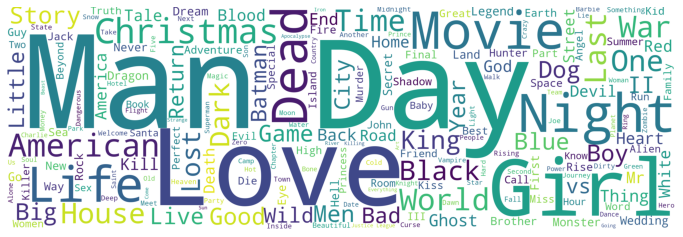

In [ ]:
title_cloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=1000, width=3000).generate(title_data)
plt.figure(figsize=(12,6))
plt.imshow(title_cloud)
plt.axis('off')
plt.show()

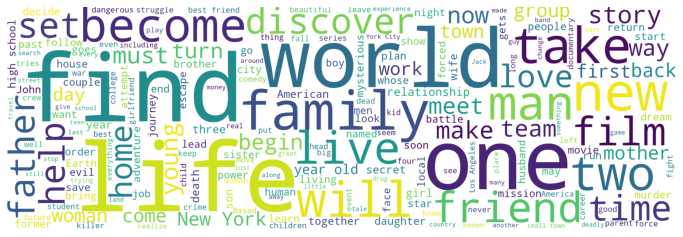

In [ ]:
overview_cloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=1000, width=3000).generate(overview_data)
plt.figure(figsize=(12,6))
plt.imshow(overview_cloud)
plt.axis('off')
plt.show()

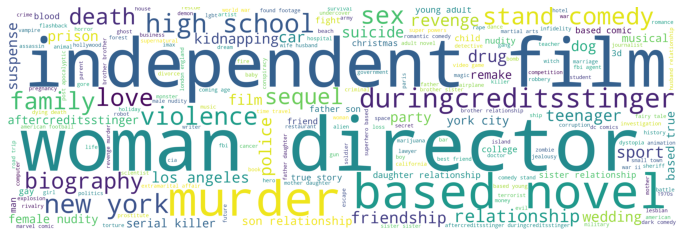

In [ ]:
keyword_cloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=1000, width=3000).generate(keyword_data)
plt.figure(figsize=(12,6))
plt.imshow(keyword_cloud)
plt.axis('off')
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

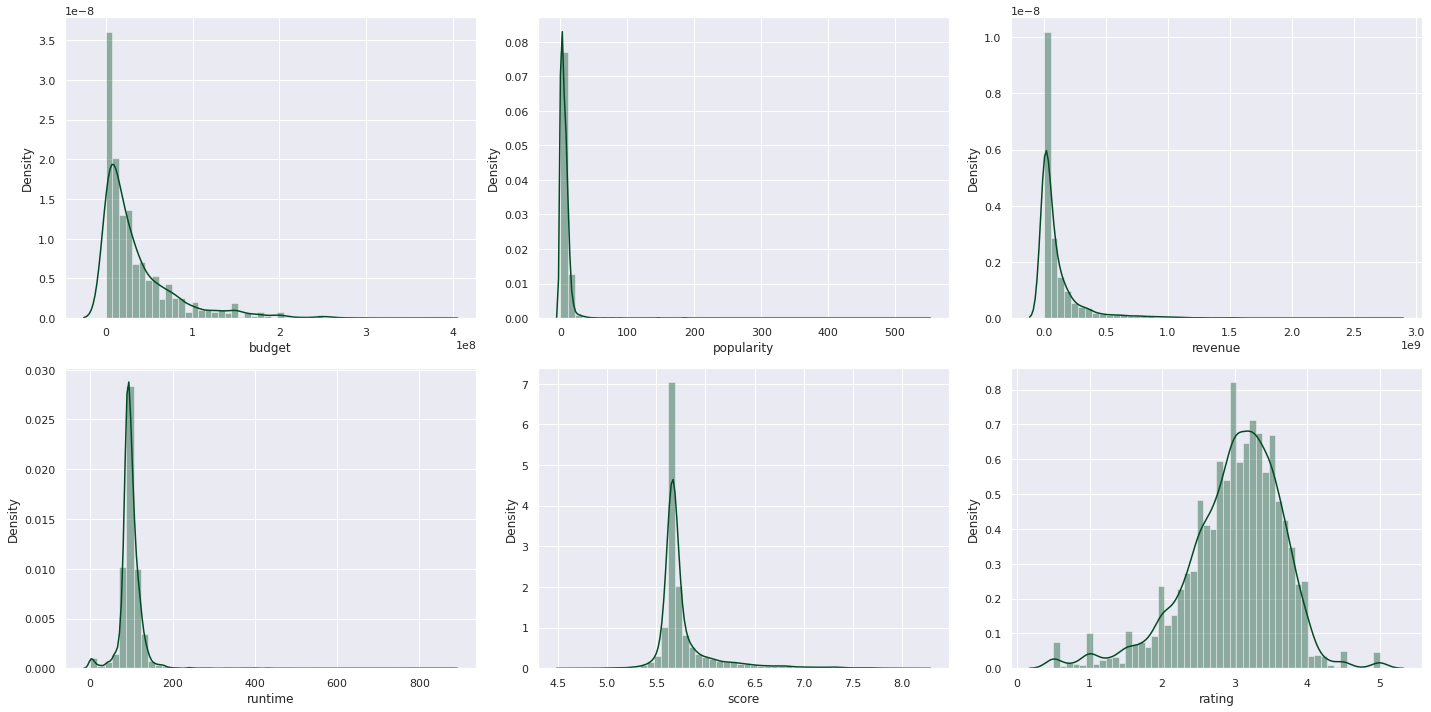

In [ ]:
plt.figure(figsize=(20,10))

col = ['budget', 'popularity', 'revenue', 'runtime', 'score', 'rating']

a = 1
for i in range(len(col)):
    plt.subplot(2, 3, a); 
    sns.distplot(movies_final[col[i]])
    plt.xlabel(col[i])
    a += 1

plt.tight_layout()


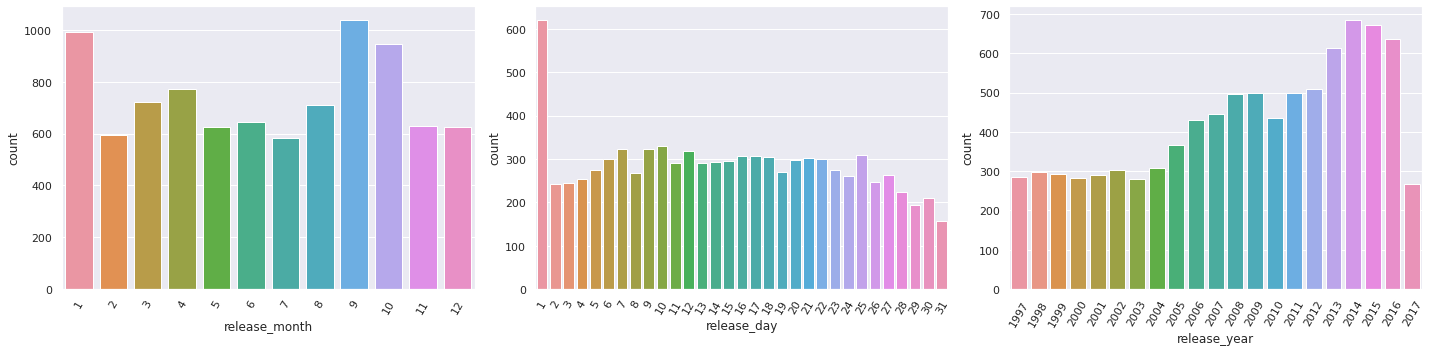

In [ ]:
plt.figure(figsize=(20,5))

col = ['release_month','release_day', 'release_year']

a = 1
for i in range(len(col)):
    plt.subplot(1, 3, a); 
    countplt = sns.countplot(movies_final[col[i]])
    countplt.set_xticklabels(countplt.get_xticklabels(),rotation = 60)
    plt.xlabel(col[i])
    
    a += 1

plt.tight_layout()


In [ ]:
movies_2 = movies_final.drop(columns=["imdb_id","id"],axis=1)

In [ ]:
movies_2['popularity'].describe()

count    8889.000000
mean        6.412849
std        11.227632
min         0.001180
25%         1.547286
50%         4.961439
75%         8.874048
max       547.488298
Name: popularity, dtype: float64

count    8889.000000
mean        6.120986
std         6.164020
min         0.001180
25%         1.547286
50%         4.961439
75%         8.874048
max        50.000000
Name: popularity_2, dtype: float64


Text(0.5, 0, 'popularity')

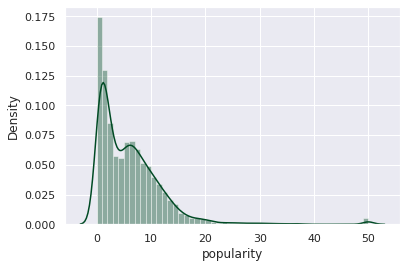

In [ ]:
# Winsorization
# Replacing extremely high popularity values with a value slightly higher than the maximum popularity 
movies_2['popularity_2'] = np.where(movies_2["popularity"]>=movies_2["popularity"].quantile(0.995), 50, movies_2["popularity"])
print(movies_2['popularity_2'].describe())
sns.distplot(movies_2['popularity_2'])
plt.xlabel('popularity')

count    8889.000000
mean        1.640542
std         0.840678
min         0.001179
25%         0.935028
50%         1.785312
75%         2.289910
max         6.307166
Name: popularity_3, dtype: float64


Text(0.5, 0, 'popularity')

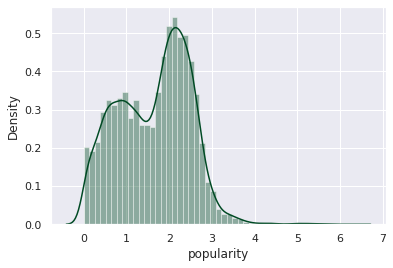

In [ ]:
# Log Transformation
# Replacing extremely high popularity values with a value slightly higher than the maximum popularity 
movies_2['popularity_3'] = np.log1p(movies_2['popularity'])
print(movies_2['popularity_3'].describe())
sns.distplot(movies_2['popularity_3'])
plt.xlabel('popularity')

In [ ]:
num_features = movies_2.select_dtypes(include=['float64','int64']).columns.values

# Compute correlations between all numerical features

corr = movies_2[num_features].corr()

In [ ]:
# Sort features by their (absolute) correlation with the target variable.

pd.DataFrame(corr.sort_values(by='popularity_2', key=abs, ascending=False)[['popularity_2', 'popularity_3']]).head(30)

,popularity_2,popularity_3
popularity_2,1.000000,0.879221
popularity_3,0.879221,1.000000
popularity,0.734073,0.600545
revenue,0.578929,0.496605
score,0.541113,0.441584
budget,0.516729,0.488076
studioSextile,-0.415771,-0.441357
leadQuintile,-0.308287,-0.408401
series,0.259874,0.247488
supportQuintile,-0.248247,-0.323083


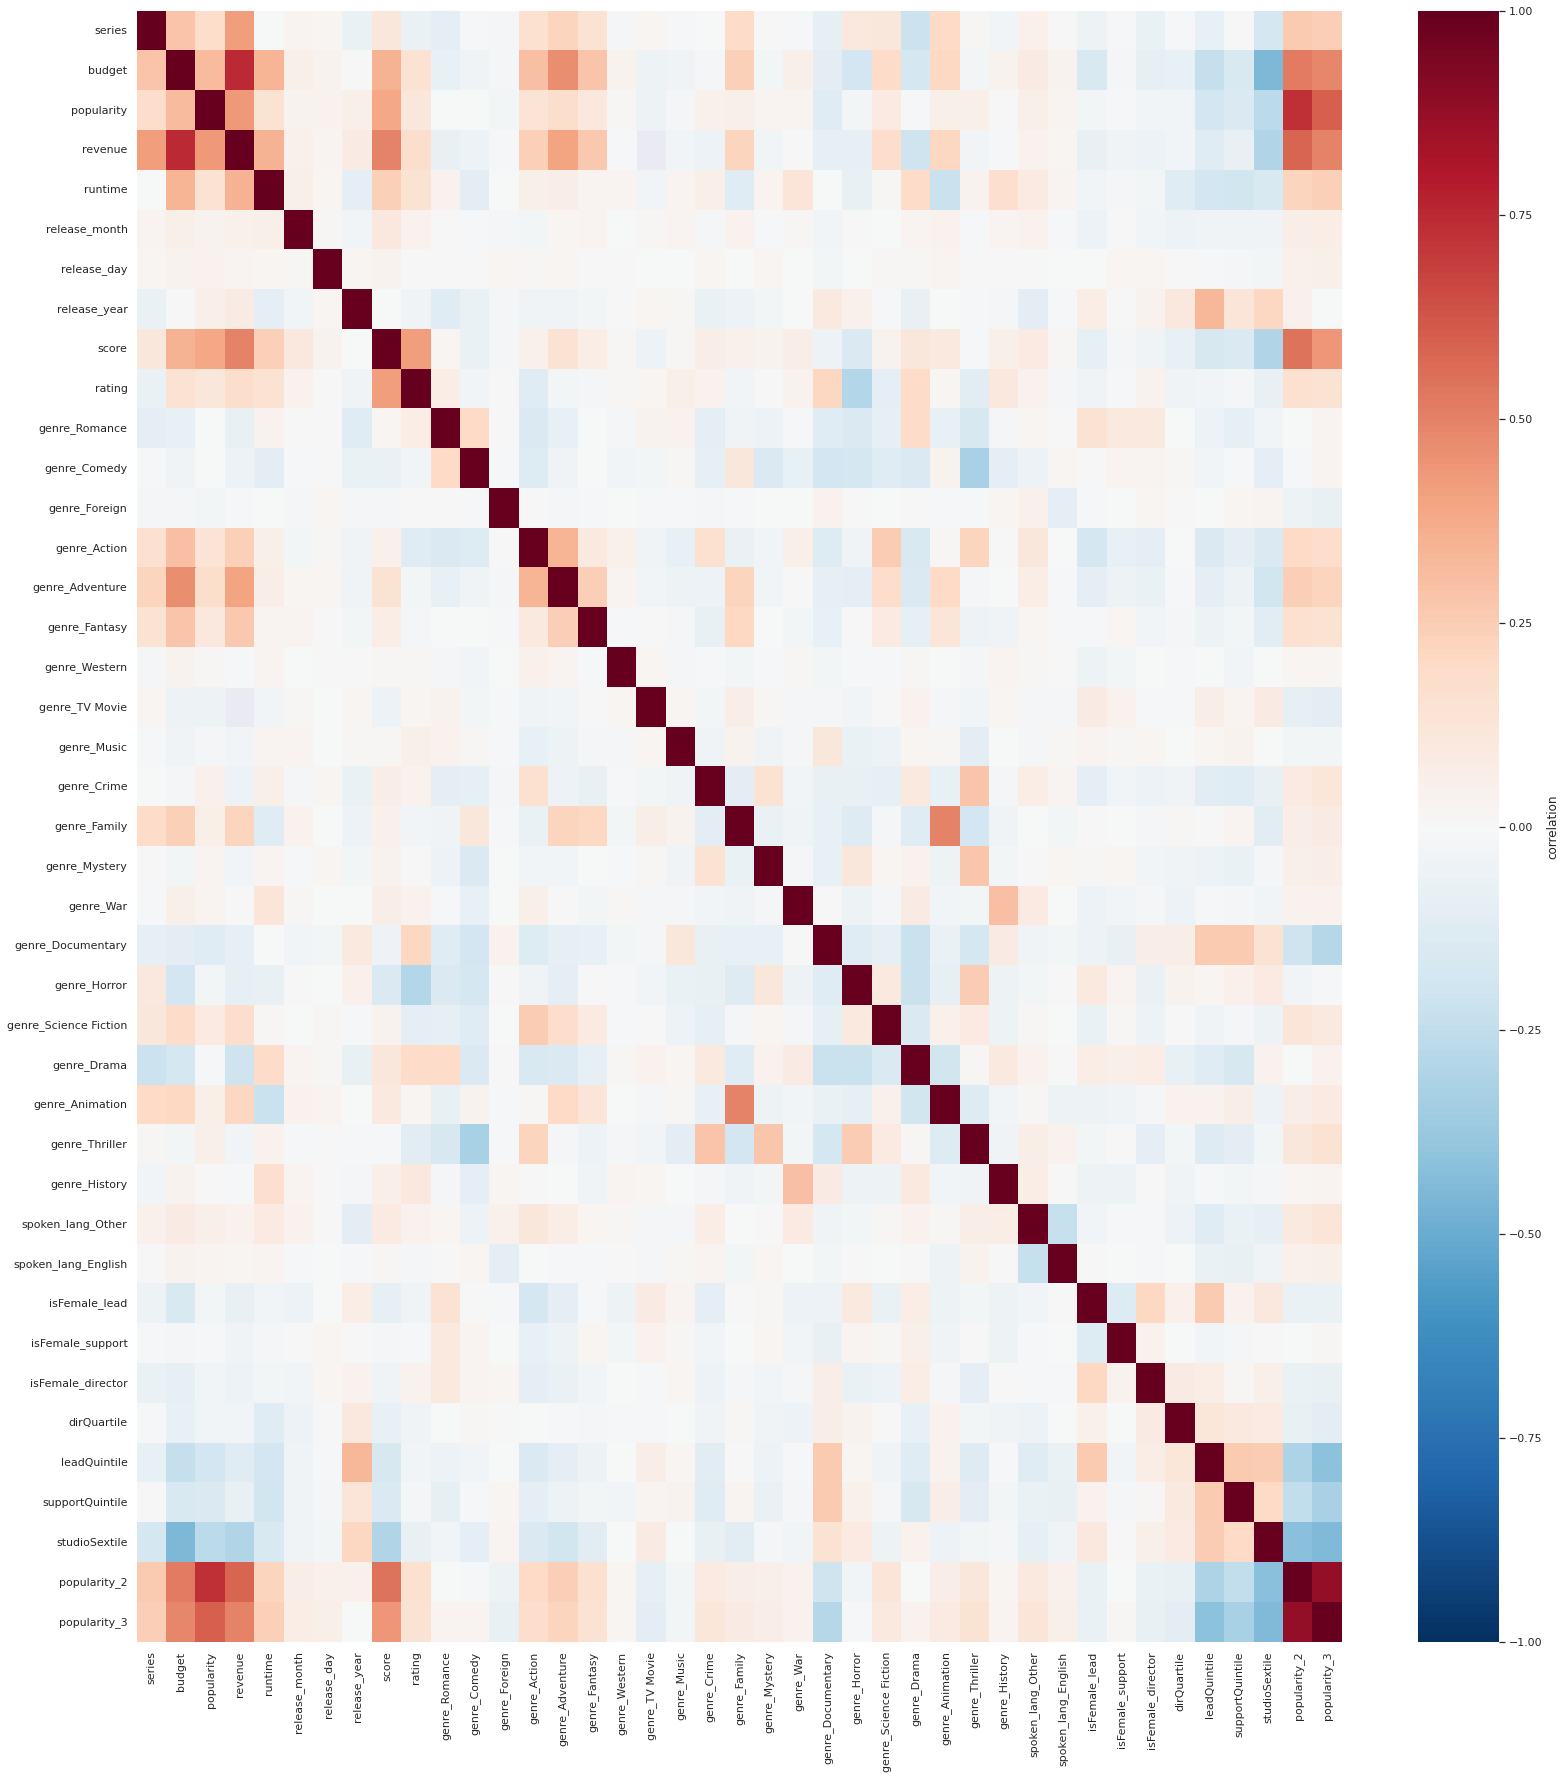

In [ ]:
# Plot correlations as a heatmap
# This could indicate that we can drop some of these features.

fig, ax = plt.subplots(figsize=(27, 30))
sns.heatmap(corr, vmin=-1, vmax=1, cmap = 'RdBu_r', xticklabels=True, yticklabels=True, cbar_kws={'label' : 'correlation'}, ax=ax)

In [ ]:
corr_df = corr.where(pd.np.triu(pd.np.ones(corr.shape), k=1).astype(bool)).stack().reset_index()
corr_df[corr_df[0]>0.7]
# Budget and Revenue have a 74% correlation
# We will remove popularity and use popularity_2 as the target 

,level_0,level_1,0
41,budget,revenue,0.742630
115,popularity,popularity_2,0.734073
818,popularity_2,popularity_3,0.879221


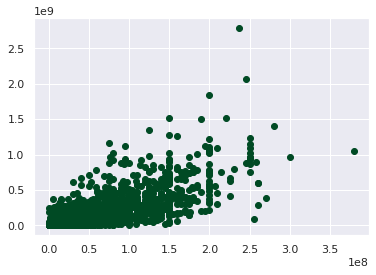

In [ ]:
plt.scatter(movies_2['budget'],movies_2['revenue'])

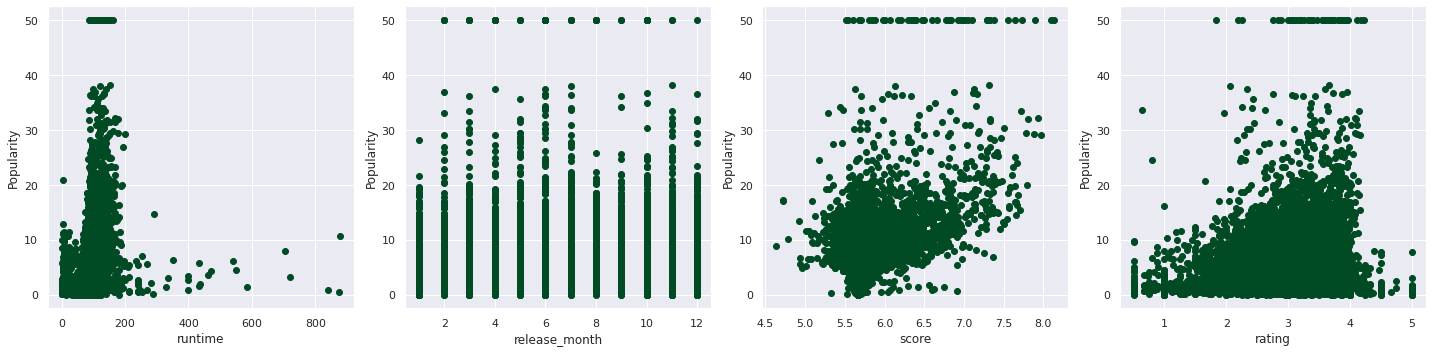

In [ ]:
plt.figure(figsize=(20,5))

col = ['runtime', 'release_month', 'score', 'rating']

a = 1
for i in range(len(col)):
    plt.subplot(1, 4, a); 
    plt.scatter(movies_2[col[i]], movies_2['popularity_2'])
    plt.xlabel(col[i])
    plt.ylabel("Popularity")
    a += 1

plt.tight_layout()

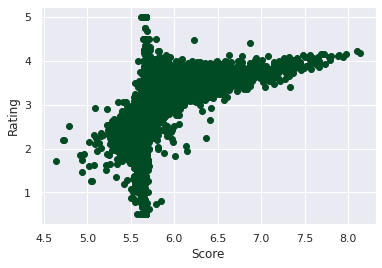

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x=movies_2['score'], y=movies_2['rating'])

plt.xlabel('Score')
plt.ylabel('Rating')
plt.show()



# Predictive Analysis

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Creating 'time_since_released' for better interpretability
movies_2["time_since_released"] = date.today().year - movies_2["release_year"]

In [ ]:
movies_2[["time_since_released","release_year","release_date"]]

,time_since_released,release_year,release_date
0,21,2001,2001-01-01
1,17,2005,2005-08-12
2,17,2005,2005-09-05
3,14,2008,2008-08-15
4,12,2010,2010-09-10
...,...,...,...
8884,9,2013,2013-05-24
8885,12,2010,2010-12-13
8886,7,2015,2015-10-09
8887,13,2009,2009-07-18


In [ ]:
movies_na = pd.DataFrame(movies_2.isna().sum())
movies_na[movies_na[0]>0]

,0
budget,4929
revenue,5442
rating,72
isFemale_lead,1920
lead,1315
isFemale_support,1511
support,345
isFemale_director,2605
director,39
keyword,1418


In [ ]:
# For prediction, we will not use budget, revenue, isFemale_lead, isFemale_support, isFemale_director because of high missing values
# We also will not use lead, support, director, keyword since these are string columns created only for descriptive analysis. 
# Also, removing release_year and popularity
# Removing the above
movies_3 = movies_2.drop(columns=["popularity","revenue","release_year","keyword","isFemale_lead","isFemale_support","isFemale_director", "lead","support",\
                                  "director","release_date", "budget"], axis=1)

In [ ]:
movies_na = pd.DataFrame(movies_3.isna().sum())
movies_na[movies_na[0]>0]

,0
rating,72


In [ ]:
# Filling missing ratings with its median
movies_3['rating'] = movies_3['rating'].replace(np.nan,movies_3['rating'].median())


In [ ]:
movies_na = pd.DataFrame(movies_3.isna().sum())
movies_na[movies_na[0]>0]

,0


# Models

In [ ]:
movies_3.head(2)

,series,runtime,title,release_month,release_day,score,rating,genre_Romance,genre_Comedy,genre_Foreign,...,studio,spoken_lang_Other,spoken_lang_English,dirQuartile,leadQuintile,supportQuintile,studioSextile,popularity_2,popularity_3,time_since_released
0,0,90,Invincible,1,1,5.676552,3.121212,0,0,0,...,Werner Herzog Filmproduktion,0,1,1,5,5,6,0.685649,0.522151,21
1,0,103,Grizzly Man,8,12,6.008312,3.825746,0,0,0,...,Discovery Docs,0,1,1,5,5,6,8.535339,2.255005,17


In [ ]:
num_features = movies_3.select_dtypes(include=['float64','int64']).columns.values
movies_3[num_features].columns

Index(['series', 'runtime', 'release_month', 'release_day', 'score', 'rating',
       'genre_Romance', 'genre_Comedy', 'genre_Foreign', 'genre_Action',
       'genre_Adventure', 'genre_Fantasy', 'genre_Western', 'genre_TV Movie',
       'genre_Music', 'genre_Crime', 'genre_Family', 'genre_Mystery',
       'genre_War', 'genre_Documentary', 'genre_Horror',
       'genre_Science Fiction', 'genre_Drama', 'genre_Animation',
       'genre_Thriller', 'genre_History', 'spoken_lang_Other',
       'spoken_lang_English', 'dirQuartile', 'leadQuintile', 'supportQuintile',
       'studioSextile', 'popularity_2', 'popularity_3', 'time_since_released'],
      dtype='object')

In [ ]:
features = movies_3[num_features]
features.drop(columns=["popularity_2","popularity_3"], axis=1, inplace=True)
target_wins = movies_3["popularity_2"]
target_log = movies_3["popularity_3"]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
bins = np.linspace(0, 50, 10)
y_binned_wins = np.digitize(target_wins, bins)
y_binned_log = np.digitize(target_log, bins)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target_wins, test_size=0.3, random_state=42, stratify=y_binned_wins)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(features, target_log, test_size=0.3, random_state=42, stratify=y_binned_log)

In [ ]:
features_GB = features.drop(columns = ["release_day", "release_month"])
features_GB.columns

Index(['series', 'runtime', 'score', 'rating', 'genre_Romance', 'genre_Comedy',
       'genre_Foreign', 'genre_Action', 'genre_Adventure', 'genre_Fantasy',
       'genre_Western', 'genre_TV Movie', 'genre_Music', 'genre_Crime',
       'genre_Family', 'genre_Mystery', 'genre_War', 'genre_Documentary',
       'genre_Horror', 'genre_Science Fiction', 'genre_Drama',
       'genre_Animation', 'genre_Thriller', 'genre_History',
       'spoken_lang_Other', 'spoken_lang_English', 'dirQuartile',
       'leadQuintile', 'supportQuintile', 'studioSextile',
       'time_since_released'],
      dtype='object')

In [ ]:
X_train_GB, X_test_GB, y_train_GB, y_test_GB = train_test_split(features_GB, target_wins, test_size=0.3, random_state=1)
X_train_log_GB, X_test_log_GB, y_train_log_GB, y_test_log_GB = train_test_split(features, target_log, test_size=0.3, random_state=1)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train_log.shape, X_test_log.shape, y_train_log.shape, y_test_log.shape)

(6222, 33) (2667, 33) (6222,) (2667,)
(6222, 33) (2667, 33) (6222,) (2667,)


In [ ]:
np.mean(y_train),np.mean(y_test),np.mean(y_train_log),np.mean(y_test_log)

(6.135839299421391, 6.08633536107986, 1.6409342077203315, 1.6396274482929978)

In [ ]:
import copy
train = X_train.copy()
train['popularity_2'] = y_train

test = X_test.copy()
test['popularity_2'] = y_test

train_log = X_train_log.copy()
train_log['popularity_3'] = y_train_log

test_log = X_test_log.copy()
test_log['popularity_3'] = y_test_log

full = train.append(test)
full_log = train_log.append(test_log)

<Figure size 1440x360 with 0 Axes>

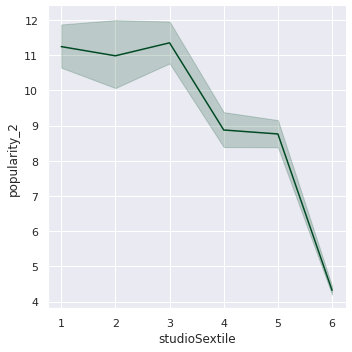

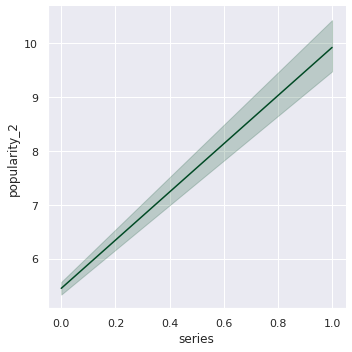

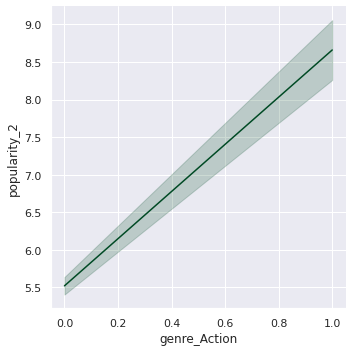

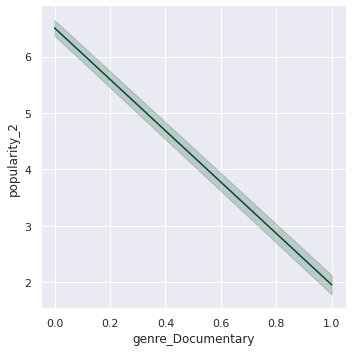

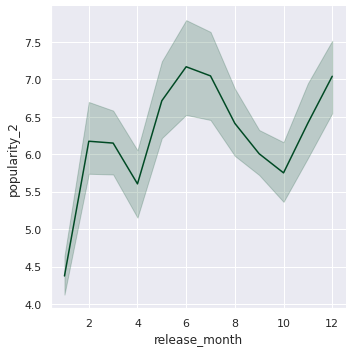

In [ ]:
plt.figure(figsize=(20,5))

col = ['studioSextile', 'series', 'genre_Action', 'genre_Documentary', 'release_month']

for i in range(len(col)):
    g = sns.relplot(x = full[col[i]], y = full['popularity_2'], kind="line", data=full)
    a += 1

plt.tight_layout()

<Figure size 1440x360 with 0 Axes>

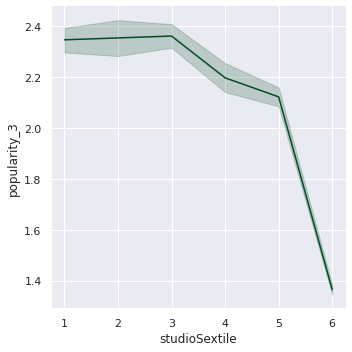

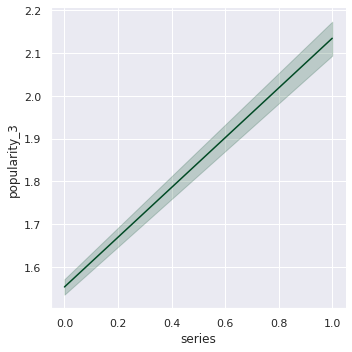

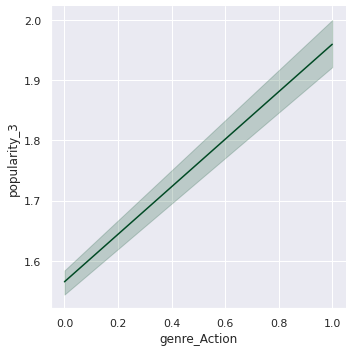

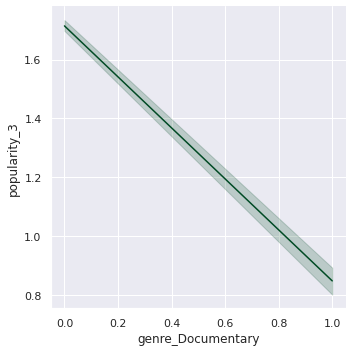

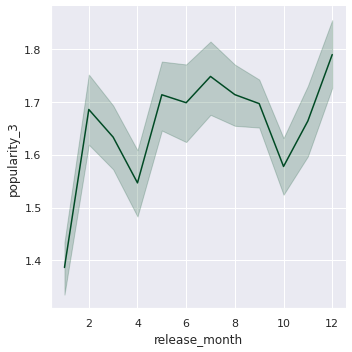

In [ ]:
plt.figure(figsize=(20,5))

col = ['studioSextile', 'series', 'genre_Action', 'genre_Documentary', 'release_month']

for i in range(len(col)):
    g = sns.relplot(x = full_log[col[i]], y = full_log['popularity_3'], kind="line", data=full_log)

plt.tight_layout()

In [ ]:
X_train.drop(columns=['release_day', 'time_since_released'], axis=1, inplace=True)
X_test.drop(columns=['release_day', 'time_since_released'], axis=1, inplace=True)

X_train_log.drop(columns=['release_day', 'time_since_released'], axis=1, inplace=True)
X_test_log.drop(columns=['release_day', 'time_since_released'], axis=1, inplace=True)

In [ ]:
# We first try out different algorithms to check the best ones and tune them

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor ,RANSACRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor

In [ ]:
models_1 = {'LinearRegression': LinearRegression(),
            'Ridge': Ridge(),
            'Lasso': Lasso(), 
            'RANSACRegressor': RANSACRegressor(),
            'ElasticNet': ElasticNet(),
            'SVR': SVR(),
            'LinearSVR': LinearSVR(),  #not a good model for the current data, can test after we edit the data
            'KNeighborsRegressor': KNeighborsRegressor(),
            'GaussianProcessRegressor':GaussianProcessRegressor(),
            'BaggingRegressor': BaggingRegressor(),
            'MLPRegressor': MLPRegressor()}

models_2 = {'RandomForestRegressor': RandomForestRegressor(),
            'GradientBoostingRegressor': GradientBoostingRegressor(),
            'XGBRegressor': XGBRegressor(),            
            'DecisionTreeRegressor': DecisionTreeRegressor(),
            'AdaBoostRegressor': AdaBoostRegressor()
            
         }  

   

In [ ]:
pd.set_option('display.max_colwidth', None)
def model_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = 5
    model.fit(X_train, y_train)
    r2_score= np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='r2', n_jobs=-1))
    r2_score_sd= np.std(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='r2', n_jobs=-1))
    adj_r2 = 1 - (1-r2_score)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
    explained_variance_score = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, 
                                                       scoring='explained_variance', n_jobs=-1))
    neg_mean_squared_error = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, 
                                                       scoring='neg_mean_squared_error', n_jobs=-1))
    neg_root_mean_squared_error = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, 
                                                       scoring='neg_root_mean_squared_error', n_jobs=-1))
    neg_root_mean_squared_error_std = np.std(cross_val_score(model, X_train, y_train, cv=strat_k_fold, 
                                                       scoring='neg_root_mean_squared_error', n_jobs=-1))    
    neg_mean_absolute_error = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, 
                                                       scoring='neg_mean_absolute_error', n_jobs=-1))
    max_error = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, 
                                                       scoring='max_error', n_jobs=-1))
    test_r2_score= model.score(X_test, y_test)
    test_adj_r2 = 1 - (1-test_r2_score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    test_mean_squared_error = mean_squared_error(y_test, model.predict(X_test))
    test_root_mean_squared_error = np.sqrt(test_mean_squared_error)
    test_mean_absolute_error = mean_absolute_error(y_test, model.predict(X_test))

    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X_train.columns),reverse = True), columns=['Value','Feature'])
    feature_imp = feature_imp[feature_imp.Value != 0]
    top_features = list(feature_imp.nlargest(5, 'Value')['Feature'])
    
   # y_pred = model.predict(X_test)

    df_model = pd.DataFrame({'model': [name],
                             'r2': [r2_score], 'r2_std': [r2_score_sd], 'test_r2': [test_r2_score], 
                             'adj_r2': [adj_r2], 'test_adj_r2': [test_adj_r2], 'top_features': [top_features],
                             'explained_variance': [explained_variance_score],
                             'neg_mean_squared_error' : [neg_mean_squared_error],'neg_mse_std': [neg_root_mean_squared_error_std], 'test_mean_squared_error': [test_mean_squared_error], 
                             'max_error' : [max_error],
                             'neg_root_mean_squared_error': [neg_root_mean_squared_error],'test_root_mean_squared_error': [test_root_mean_squared_error], 
                             'neg_mean_absolute_error': [neg_mean_absolute_error], 'test_mean_absolute_error': [test_mean_absolute_error]})   
    return df_model

def model_report_2(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = 5
    model.fit(X_train, y_train)
    r2_score= np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='r2', n_jobs=-1))
    r2_score_sd= np.std(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='r2', n_jobs=-1))
    adj_r2 = 1 - (1-r2_score)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
    explained_variance_score = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, 
                                                       scoring='explained_variance', n_jobs=-1))
    neg_mean_squared_error = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, 
                                                       scoring='neg_mean_squared_error', n_jobs=-1))
    neg_root_mean_squared_error = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, 
                                                       scoring='neg_root_mean_squared_error', n_jobs=-1))
    neg_root_mean_squared_error_std = np.std(cross_val_score(model, X_train, y_train, cv=strat_k_fold, 
                                                       scoring='neg_root_mean_squared_error', n_jobs=-1))    
    neg_mean_absolute_error = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, 
                                                       scoring='neg_mean_absolute_error', n_jobs=-1))
    max_error = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, 
                                                       scoring='max_error', n_jobs=-1))
    test_r2_score= model.score(X_test, y_test)
    test_adj_r2 = 1 - (1-test_r2_score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    test_mean_squared_error = mean_squared_error(y_test, model.predict(X_test))
    test_root_mean_squared_error = np.sqrt(test_mean_squared_error)
    test_mean_absolute_error = mean_absolute_error(y_test, model.predict(X_test))

    top_features = []
    
   # y_pred = model.predict(X_test)

    df_model = pd.DataFrame({'model': [name],
                             'r2': [r2_score], 'r2_std': [r2_score_sd], 'test_r2': [test_r2_score], 
                             'adj_r2': [adj_r2], 'test_adj_r2': [test_adj_r2], 'top_features': [top_features],
                             'explained_variance': [explained_variance_score],
                             'neg_mean_squared_error' : [neg_mean_squared_error],'neg_mse_std': [neg_root_mean_squared_error_std], 'test_mean_squared_error': [test_mean_squared_error], 
                             'max_error' : [max_error],
                             'neg_root_mean_squared_error': [neg_root_mean_squared_error],'test_root_mean_squared_error': [test_root_mean_squared_error], 
                             'neg_mean_absolute_error': [neg_mean_absolute_error], 'test_mean_absolute_error': [test_mean_absolute_error]})   
    return df_model    


In [ ]:
models_df_result = pd.concat([model_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models_2.items()])
# Without loss of generality, assuming that the top models will be the same for both types of target variables

[20:07:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
models_df_result_2 = pd.concat([model_report_2(model, X_train, X_test, y_train, y_test, name) for (name, model) in models_1.items()])
models_df_result_combined = models_df_result.append(models_df_result_2)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
models_df_result_combined.sort_values(by = ['adj_r2', 'r2_std'], ascending = [False, True])

,model,r2,r2_std,test_r2,adj_r2,test_adj_r2,top_features,explained_variance,neg_mean_squared_error,neg_mse_std,test_mean_squared_error,max_error,neg_root_mean_squared_error,test_root_mean_squared_error,neg_mean_absolute_error,test_mean_absolute_error
0,XGBRegressor,0.552204,0.018320,0.565661,0.549962,0.560552,"[studioSextile, score, series, genre_Action, genre_Documentary]",0.553187,-16.938444,0.098381,16.584345,-40.131446,-4.114458,4.072388,-2.498534,2.472978
0,GradientBoostingRegressor,0.548549,0.019495,0.565321,0.546288,0.560207,"[score, studioSextile, rating, runtime, genre_Action]",0.549147,-17.081753,0.116951,16.597341,-40.134532,-4.132213,4.073983,-2.504764,2.474839
0,RandomForestRegressor,0.529680,0.026635,0.544726,0.527324,0.539369,"[score, rating, studioSextile, runtime, release_month]",0.534325,-17.671032,0.083761,17.383738,-39.176275,-4.207765,4.169381,-2.580994,2.535712
0,BaggingRegressor,0.499837,0.028040,0.519306,0.497332,0.513650,[],0.491570,-19.688330,0.043303,18.354350,-39.502503,-4.358213,4.284198,-2.672017,2.645299
0,Ridge,0.456208,0.017466,0.444399,0.453485,0.437863,[],0.457445,-20.569733,0.091898,21.214498,-41.492484,-4.534456,4.605920,-2.993602,3.020231
0,LinearRegression,0.456182,0.017483,0.444365,0.453459,0.437828,[],0.457424,-20.570610,0.091681,21.215811,-41.488153,-4.534557,4.606062,-2.994132,3.020554
0,MLPRegressor,0.436951,0.033810,0.433397,0.434131,0.426732,[],0.441293,-21.704988,0.133527,21.634578,-41.552392,-4.623322,4.651298,-2.971163,2.861749
0,ElasticNet,0.247406,0.016909,0.235819,0.243637,0.226829,[],0.248104,-28.506853,0.165960,29.178693,-43.972711,-5.336601,5.401731,-3.534408,3.578769
0,KNeighborsRegressor,0.245514,0.040750,0.274287,0.241735,0.265750,[],0.251576,-28.548914,0.174367,27.709875,-44.474659,-5.340272,5.264017,-3.461759,3.371267
0,Lasso,0.220035,0.016332,0.208089,0.216129,0.198773,[],0.220759,-29.542412,0.165651,30.237510,-44.216066,-5.432768,5.498864,-3.626257,3.663084


In [ ]:
# Based on the above results, we will go ahead with XGBRegressor, GradientBoostingRegressor, RandomForestRegressor, and BaggingRegressor, and choose the best.

## XGBRegressor

In [ ]:
# GridSearchCV to get the best hyperparameters for winsorized target - using gamma regression since right skewed
xgb1 = XGBRegressor(random_state=42)
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:gamma'],
              'learning_rate': [0.03, .07, 0.1], #so called `eta` value
              'max_depth': [5, 9],
              'min_child_weight': [7, 15],
              'silent': [1],
              'subsample': [0.7, 1],
              'colsample_bytree': [0.7, 1],
              'n_estimators': [700, 1000], 
              'eval_metric': ['gamma-deviance'],
              'gamma': [10]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3, 
                        n_jobs = 5,
                        verbose=True, scoring='r2')

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
0.5467667073923925
{'colsample_bytree': 1, 'eval_metric': 'gamma-deviance', 'gamma': 10, 'learning_rate': 0.07, 'max_depth': 9, 'min_child_weight': 7, 'n_estimators': 1000, 'nthread': 4, 'objective': 'reg:gamma', 'silent': 1, 'subsample': 0.7}


In [ ]:
xgbr_wins = XGBRegressor(verbosity=0, random_state=42, colsample_bytree=1, learning_rate=0.1, max_depth=9, min_child_weight=7, n_estimators=1000, nthread=4, \
                         objective='reg:gamma', silent=1, subsample=0.7, gamma=10, eval_metric='gamma-deviance') 
xgbr_wins.fit(X_train, y_train)
# taking learning_rate = 0.1 gives better results than 0.07

XGBRegressor(eval_metric='gamma-deviance', gamma=10, max_depth=9,
             min_child_weight=7, n_estimators=1000, nthread=4,
             objective='reg:gamma', random_state=42, silent=1, subsample=0.7,
             verbosity=0)

In [ ]:
# Performance on Train

r2 = xgbr_wins.score(X_train, y_train)  
mse = mean_squared_error(y_train, xgbr_wins.predict(X_train))
mae = mean_absolute_error(y_train, xgbr_wins.predict(X_train))
mape = mean_absolute_percentage_error(y_train, xgbr_wins.predict(X_train))
adj_r2 = 1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)

print("Train RMSE: %.2f" % (mse**(1/2.0)))
print("Train Adjusted R2: ", adj_r2)

Train RMSE: 3.88
Train Adjusted R2:  0.6011953750244108


In [ ]:
# Performance on Test

y_pred = xgbr_wins.predict(X_test)

r2 = xgbr_wins.score(X_test, y_test)  
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

print("Test RMSE: %.2f" % (mse**(1/2.0)))
print("Test Adjusted R2: ", adj_r2)

Test RMSE: 4.07
Test Adjusted R2:  0.5620340095442362


In [ ]:
# GridSearchCV to get the best hyperparameters for log transformed target 
xgb2 = XGBRegressor(random_state=42)
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.03, .07, 0.1], #so called `eta` value
              'max_depth': [5, 9],
              'min_child_weight': [15, 30],
              'silent': [1],
              'subsample': [0.7, 1],
              'colsample_bytree': [0.7, 1],
              'n_estimators': [200, 300],
              'eval_metric': ['rmse']}

xgb_grid_log = GridSearchCV(xgb2,
                        parameters,
                        cv = 3, 
                        n_jobs = 5,
                        verbose=True, scoring='r2')

xgb_grid_log.fit(X_train_log, y_train_log)

print(xgb_grid_log.best_score_)
print(xgb_grid_log.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
0.6929871044116013
{'colsample_bytree': 0.7, 'eval_metric': 'rmse', 'learning_rate': 0.03, 'max_depth': 9, 'min_child_weight': 30, 'n_estimators': 200, 'nthread': 4, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.7}


In [ ]:
xgbr_log = XGBRegressor(verbosity=0, random_state=42, colsample_bytree=0.7, learning_rate=0.03, max_depth=5, min_child_weight=30, n_estimators=200, nthread=4, \
                    objective='reg:squarederror', silent=1, subsample=0.7, reg_lambda=1, reg_alpha=0, eval_metric='rmse') 
xgbr_log.fit(X_train_log, y_train_log)

XGBRegressor(colsample_bytree=0.7, eval_metric='rmse', learning_rate=0.03,
             max_depth=5, min_child_weight=30, n_estimators=200, nthread=4,
             objective='reg:squarederror', random_state=42, silent=1,
             subsample=0.7, verbosity=0)

In [ ]:
# Performance on Train
pred = xgbr_log.predict(X_train_log)
r2 = xgbr_log.score(X_train_log, y_train_log)  
mse_wo_exp = mean_squared_error(y_train_log, pred)
mse = mean_squared_error(np.expm1(y_train_log), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_train_log), np.expm1(pred))
mape = mean_absolute_percentage_error(np.expm1(y_train_log), np.expm1(pred))
adj_r2 = 1 - (1-r2)*(len(y_train_log)-1)/(len(y_train_log)-X_train_log.shape[1]-1)

print("Train RMSE: %.2f" % (mse**(1/2.0)))
print("Train RMSE w/o exp: %.2f" % (mse_wo_exp**(1/2.0)))
print("Train Adjusted R2: ", adj_r2)

Train RMSE: 9.55
Train RMSE w/o exp: 0.43
Train Adjusted R2:  0.7351112642677061


In [ ]:
# Performance on Test

y_pred_log = xgbr_log.predict(X_test_log)

r2 = xgbr_log.score(X_test_log, y_test_log)  
mse_wo_exp = mean_squared_error(y_test_log, xgbr_log.predict(X_test_log))
mse = mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_log))
mae = mean_absolute_error(np.expm1(y_test_log), np.expm1(y_pred_log))
mape = mean_absolute_percentage_error(np.expm1(y_test_log), np.expm1(y_pred_log))
adj_r2 = 1 - (1-r2)*(len(y_test_log)-1)/(len(y_test_log)-X_test_log.shape[1]-1)

print("Test RMSE: %.2f" % (mse**(1/2.0)))
print("Train RMSE w/o exp: %.2f" % (mse_wo_exp**(1/2.0)))
print("Test Adjusted R2: ", adj_r2)

Test RMSE: 9.99
Train RMSE w/o exp: 0.47
Test Adjusted R2:  0.6917200126037188


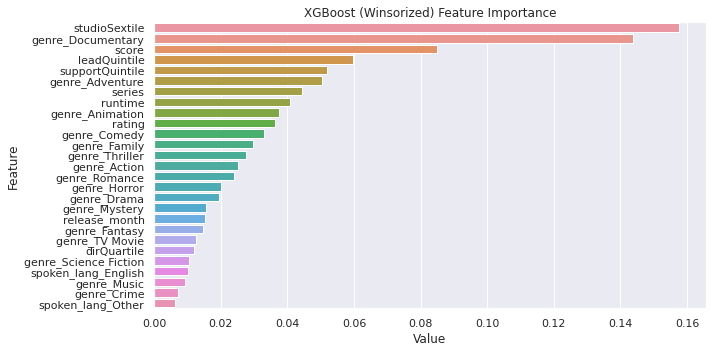

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(xgbr_wins.feature_importances_, X_train.columns),reverse = True), columns=['Value','Feature'])
feature_imp = feature_imp[feature_imp.Value != 0]
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGBoost (Winsorized) Feature Importance')
plt.tight_layout()
plt.show()

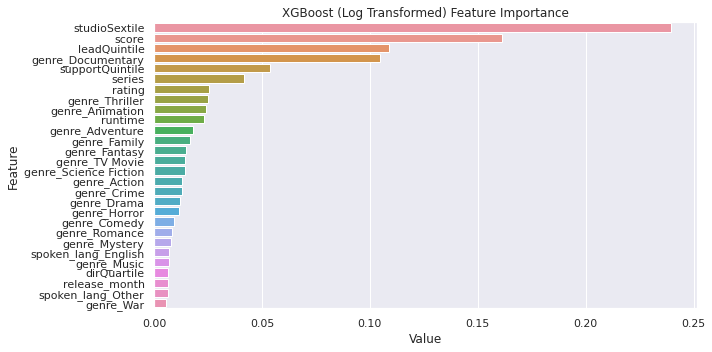

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(xgbr_log.feature_importances_, X_train_log.columns),reverse = True), columns=['Value','Feature'])
feature_imp = feature_imp[feature_imp.Value != 0]
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGBoost (Log Transformed) Feature Importance')
plt.tight_layout()
plt.show()

## Random Forest Regressor

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFE

In [ ]:
# scaling to test for regression
# reference: https://towardsdatascience.com/how-data-normalization-affects-your-random-forest-algorithm-fbc6753b4ddf

scalerS = StandardScaler()
scalerM = MinMaxScaler()

X_train_std = scalerS.fit_transform(X_train)
X_test_std = scalerS.fit_transform(X_test)

X_train_norm = scalerM.fit_transform(X_train)
X_test_norm = scalerM.fit_transform(X_test)

In [ ]:
def rfrmodelsummary(name, X_train, X_test, y_train, y_test, model):
    
    model.fit(X_train, y_train)
    
    # training
    y_pred_train = model.predict(X_train)
    
    # training metrics
    mse_train = mean_squared_error(y_train, y_pred_train, squared=True)
    rmse_train = np.sqrt(mse_train)
    rsq_train = model.score(X_train, y_train)
    adjrsq_train = 1 - (((len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))*(1-rsq_train))
    
    # test
    y_pred_test = model.predict(X_test)
    
    # test metrics
    mse_test = mean_squared_error(y_test, y_pred_test, squared=True)
    rmse_test = np.sqrt(mse_test)
    rsq_test = model.score(X_test, y_test)
    adjrsq_test = 1 - (((len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))*(1-rsq_test))
    
    df_model = pd.DataFrame({'model': [name],
                             'R2_train': [rsq_train], 'R2_test': [rsq_test],
                             'AdjR2_train': [adjrsq_train], 'AdjR2_test': [adjrsq_test], 
                             'MSE_train': [mse_train], 'MSE_test' : [mse_test],
                             'RMSE_train': [rmse_train], 'RMSE_test' : [rmse_test]})   
    
    return df_model

In [ ]:
def plotrfr(name, X_train, X_test, y_train, y_test, model):
    
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    plotdata = [y_pred_train, y_pred_test]
    
    return plotdata

In [ ]:
rfr = RandomForestRegressor(random_state=42, n_jobs=-1)

In [ ]:
rfr_models_result = pd.concat([rfrmodelsummary('Baseline', X_train, X_test, y_train, y_test, rfr), 
                               rfrmodelsummary('Standardized', X_train_std, X_test_std, y_train, y_test, rfr), 
                               rfrmodelsummary('Normalized', X_train_norm, X_test_norm, y_train, y_test, rfr)])

rfr_models_result

,model,R2_train,R2_test,AdjR2_train,AdjR2_test,MSE_train,MSE_test,RMSE_train,RMSE_test
0,Baseline,0.934352,0.545656,0.934024,0.540311,2.488551,17.348193,1.577514,4.165116
0,Standardized,0.934366,0.543162,0.934038,0.537787,2.488026,17.443439,1.577348,4.176534
0,Normalized,0.934193,-0.050233,0.933863,-0.062589,2.494605,40.101039,1.579432,6.332538


=> STICK WITH NON-STANDARDIZED/NON-NORMALIZED DATA

In [ ]:
plotdata = plotrfr('Baseline', X_train, X_test, y_train, y_test, rfr)

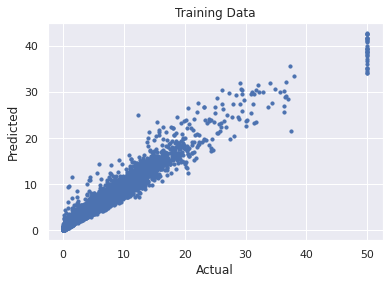

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x=y_train, y=plotdata[0], s=10, c='b')

plt.title('Training Data')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

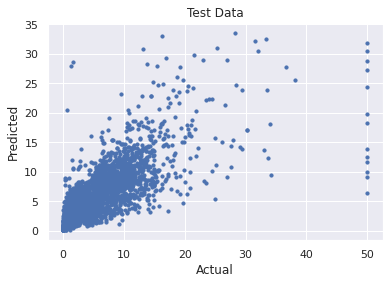

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x=y_test, y=plotdata[1], s=10, c='b')
    
plt.title('Test Data')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

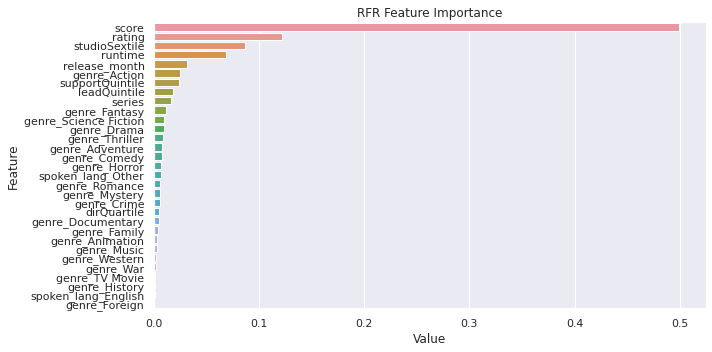

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(rfr.feature_importances_, X_train.columns),reverse = True), columns=['Value','Feature'])
feature_imp = feature_imp[feature_imp.Value != 0]
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('RFR Feature Importance')
plt.tight_layout()
plt.show()

=> POOR TEST PERFORMANCE (OVERFITTING). TRY FEATURE SELECTION

In [ ]:
RFEselector = RFE(estimator=rfr, n_features_to_select=7, step=1)
RFEselector.fit(X_train, y_train)
X_train.columns[RFEselector.get_support()]

Index(['runtime', 'release_month', 'score', 'rating', 'genre_Action',
       'supportQuintile', 'studioSextile'],
      dtype='object')

In [ ]:
RFEselector.ranking_

array([ 3,  1,  1,  1,  1, 12,  9, 25,  1,  8,  5, 20, 24, 19, 14, 17, 13,
       21, 16, 11,  4,  6, 18,  7, 22, 10, 23, 15,  2,  1,  1])

In [ ]:
X_train.columns

Index(['series', 'runtime', 'release_month', 'score', 'rating',
       'genre_Romance', 'genre_Comedy', 'genre_Foreign', 'genre_Action',
       'genre_Adventure', 'genre_Fantasy', 'genre_Western', 'genre_TV Movie',
       'genre_Music', 'genre_Crime', 'genre_Family', 'genre_Mystery',
       'genre_War', 'genre_Documentary', 'genre_Horror',
       'genre_Science Fiction', 'genre_Drama', 'genre_Animation',
       'genre_Thriller', 'genre_History', 'spoken_lang_Other',
       'spoken_lang_English', 'dirQuartile', 'leadQuintile', 'supportQuintile',
       'studioSextile'],
      dtype='object')

In [ ]:
X_train_rfe = RFEselector.transform(X_train)
X_test_rfe = RFEselector.transform(X_test)

In [ ]:
rfe_models_result = pd.concat([rfrmodelsummary('Baseline', X_train, X_test, y_train, y_test, RFEselector), 
                               rfrmodelsummary('Standardized', X_train_std, X_test_std, y_train, y_test, RFEselector), 
                               rfrmodelsummary('Normalized', X_train_norm, X_test_norm, y_train, y_test, RFEselector)])

rfe_models_result

,model,R2_train,R2_test,AdjR2_train,AdjR2_test,MSE_train,MSE_test,RMSE_train,RMSE_test
0,Baseline,0.931690,0.514256,0.931347,0.508541,2.589499,18.547167,1.609192,4.306642
0,Standardized,0.931657,0.510883,0.931315,0.505129,2.590738,18.675943,1.609577,4.321567
0,Normalized,0.931608,-0.104185,0.931265,-0.117176,2.592591,42.161094,1.610153,6.493157


In [ ]:
SFMselector = SelectFromModel(estimator=rfr)
SFMselector.fit(X_train, y_train)
X_train.columns[SFMselector.get_support()]

Index(['runtime', 'score', 'rating', 'studioSextile'], dtype='object')

In [ ]:
X_train_sfm = SFMselector.transform(X_train)
X_test_sfm = SFMselector.transform(X_test)

In [ ]:
sfm_models_result = rfrmodelsummary('Baseline', X_train_sfm, X_test_sfm, y_train, y_test, rfr)
sfm_models_result

,model,R2_train,R2_test,AdjR2_train,AdjR2_test,MSE_train,MSE_test,RMSE_train,RMSE_test
0,Baseline,0.929314,0.490455,0.929268,0.48969,2.67956,19.455941,1.636936,4.410889


=> TRY TUNING HYPERPARAMETERS

In [ ]:
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Info to help with tuning

print(rfr.estimators_[5].tree_.max_depth) # check how many nodes in the longest path
rfr.estimators_[5].tree_.n_node_samples # check how many samples in the last nodes

30


array([3991, 3152,  700, ...,    1,    1,    1], dtype=int64)

In [ ]:
# Extract data on single tree 

rfr_dict = {
    'id_node': list(range(rfr.estimators_[5].tree_.node_count)),
    'impurity': rfr.estimators_[5].tree_.impurity,
    'samples': rfr.estimators_[5].tree_.n_node_samples,
    'id_left_child': rfr.estimators_[5].tree_.children_left,
    'id_right_child': rfr.estimators_[5].tree_.children_right
}

impurity_df = pd.DataFrame(rfr_dict)
print(impurity_df.shape)
impurity_df.head(10)

(7965, 5)


,id_node,impurity,samples,id_left_child,id_right_child
0,0,36.220863,3991,1,6300
1,1,18.359111,3152,2,1401
2,2,22.486538,700,3,1282
3,3,15.751928,640,4,465
4,4,11.204722,231,5,298
5,5,9.302857,147,6,177
6,6,7.401123,86,7,116
7,7,6.748191,55,8,73
8,8,8.074572,33,9,70
9,9,5.703282,31,10,29


In [ ]:
# Calculate min_impurity_decrease

impurity_df['impurity_decrease'] = np.nan
samples_total = rfr.estimators_[5].tree_.node_count

for idx in impurity_df.index[1:]:  
    if impurity_df.iloc[idx]['id_left_child'] == -1:
        continue 
    else:
        impurity_P, samples_P = impurity_df.iloc[idx][['impurity', 'samples']]
        id_L, id_R = impurity_df.iloc[idx][['id_left_child', 'id_right_child']].astype(int)
        impurity_L, samples_L = impurity_df.iloc[id_L][['impurity', 'samples']]
        impurity_R, samples_R = impurity_df.iloc[id_R][['impurity', 'samples']]
        
        impurity_decrease = samples_P / samples_total * (
            impurity_P - samples_R / samples_P * impurity_R - 
            samples_L / samples_P * impurity_L
            )
        impurity_df.at[idx, 'impurity_decrease'] = impurity_decrease

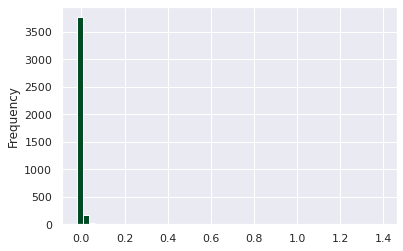

In [ ]:
impurity_df['impurity_decrease'].plot(kind='hist', bins=50)

In [ ]:
impurity_df['impurity_decrease'].describe() # 75% of values for impurity decrease lie below 0.002; use this as upper-bound for param

count    3981.000000
mean        0.003322
std         0.031887
min        -0.020922
25%         0.000012
50%         0.000133
75%         0.001132
max         1.390042
Name: impurity_decrease, dtype: float64

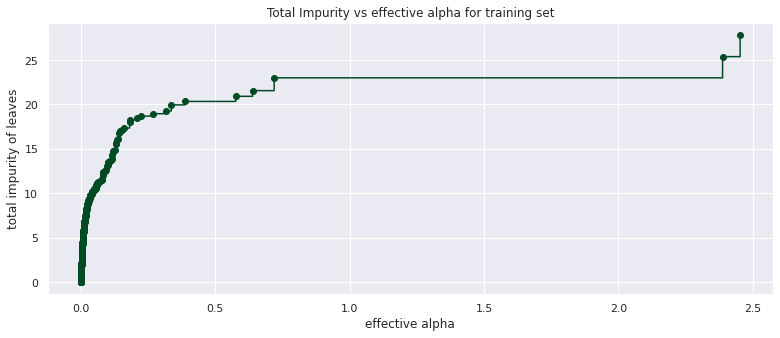

In [ ]:
# Figure out ccp_alphas

path = rfr.estimators_[5].cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(figsize=(13,5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")  
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [ ]:
# Tune parameters with random search

# param_distributions = {
#     'ccp_alpha': 0.0,
#     'max_depth': None,
#     'max_leaf_nodes': None,
#     'min_impurity_decrease': 0.0,
#     'min_impurity_split': None,
#     'min_samples_leaf': 1,
#     'min_samples_split': 2,
#     'min_weight_fraction_leaf': 0.0,
#     'max_features': 'auto'
# }

ccp_alpha = list(np.round(np.linspace(0,0.8,4), decimals=3))
max_depth = list(range(25,40,5))
max_leaf_nodes = [None] + list(range(2,20))
min_impurity_decrease = list(np.linspace(0, 0.001, 4))
min_samples_leaf = [1,2,5,10,50] #list(range(1, 51, 10))
min_samples_split = [2,5,10,15,20,50,100] #list(range(10,100,10))
max_features = ['auto', 'sqrt']
n_estimators = [500]
        
param_distributions = {
    'ccp_alpha': ccp_alpha,
    'max_depth': max_depth,
    'max_leaf_nodes': max_leaf_nodes,
    'min_impurity_decrease': min_impurity_decrease,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'max_features': max_features,
    'n_estimators': n_estimators
}

tuning_options = len(ccp_alpha) * len(max_depth) * len(max_leaf_nodes) * len(min_impurity_decrease) * len(min_samples_leaf) * len(min_samples_split) * len(max_features) * len(n_estimators)
print(tuning_options)

63840


In [ ]:
randomSearch = RandomizedSearchCV(rfr, param_distributions, cv=5, n_jobs=-1, random_state=42, n_iter=100)

In [ ]:
randomSearch.fit(X_train, y_train)
print('Best score:', randomSearch.best_score_)
print('Best parameters:', randomSearch.best_params_)

Best score: 0.5287041038720535
Best parameters: {'n_estimators': 500, 'min_samples_split': 15, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0006666666666666666, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 25, 'ccp_alpha': 0.0}


In [ ]:
rfrRCV_models_result = rfrmodelsummary('Baseline', X_train, X_test, y_train, y_test, randomSearch.best_estimator_)
rfrRCV_models_result

,model,R2_train,R2_test,AdjR2_train,AdjR2_test,MSE_train,MSE_test,RMSE_train,RMSE_test
0,Baseline,0.648248,0.543575,0.646487,0.538205,13.334121,17.427674,3.651592,4.174647


In [ ]:
randomSearch.fit(X_train_rfe, y_train)
print('Best score:', randomSearch.best_score_)
print('Best parameters:', randomSearch.best_params_)

Best score: 0.5262582872891539
Best parameters: {'n_estimators': 500, 'min_samples_split': 15, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0006666666666666666, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 25, 'ccp_alpha': 0.0}


In [ ]:
rfrRCV_models_result = rfrmodelsummary('Baseline', X_train_rfe, X_test_rfe, y_train, y_test, randomSearch.best_estimator_)
rfrRCV_models_result

,model,R2_train,R2_test,AdjR2_train,AdjR2_test,MSE_train,MSE_test,RMSE_train,RMSE_test
0,Baseline,0.671191,0.540312,0.670821,0.539102,12.464421,17.552257,3.530499,4.189541


In [ ]:
randomSearch.fit(X_train_sfm, y_train)
print('Best score:', randomSearch.best_score_)
print('Best parameters:', randomSearch.best_params_)

Best score: 0.5258543398407611
Best parameters: {'n_estimators': 500, 'min_samples_split': 15, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0006666666666666666, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 25, 'ccp_alpha': 0.0}


In [ ]:
rfrRCV_models_result = rfrmodelsummary('Baseline', X_train_sfm, X_test_sfm, y_train, y_test, randomSearch.best_estimator_)
rfrRCV_models_result

,model,R2_train,R2_test,AdjR2_train,AdjR2_test,MSE_train,MSE_test,RMSE_train,RMSE_test
0,Baseline,0.686742,0.533266,0.68654,0.532564,11.874916,17.82131,3.446,4.221529


In [ ]:
# Fine tune parameters w/ grid search

max_depth = [23,24,25,26,27]
min_impurity_decrease = [0.0005]
min_samples_split = [14,15,16]
max_features = ['sqrt']
min_samples_leaf = [3,4,5,6,7]
n_estimators = [500]

param_grid = {
    'max_depth': max_depth,
    'min_impurity_decrease': min_impurity_decrease,
    'min_samples_split': min_samples_split,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'n_estimators': n_estimators
}

tuning_options = len(max_depth) * len(min_impurity_decrease) * len(min_samples_split) * len(max_features) * len(min_samples_leaf) * len(n_estimators)
print(tuning_options)

75


In [ ]:
gridSearch = GridSearchCV(rfr, param_grid, cv=5, n_jobs=-1) 

In [ ]:
gridSearch.fit(X_train, y_train)
print('Best score:', gridSearch.best_score_)
print('Best parameters:', gridSearch.best_params_)

Best score: 0.534003959036765
Best parameters: {'max_depth': 23, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0005, 'min_samples_leaf': 3, 'min_samples_split': 14, 'n_estimators': 500}


In [ ]:
rfrGCV_models_result = rfrmodelsummary('Baseline', X_train, X_test, y_train, y_test, gridSearch.best_estimator_) 
rfrGCV_models_result

,model,R2_train,R2_test,AdjR2_train,AdjR2_test,MSE_train,MSE_test,RMSE_train,RMSE_test
0,Baseline,0.678631,0.549348,0.677021,0.544046,12.182404,17.207233,3.49033,4.14816


In [ ]:
gridSearch.fit(X_train_rfe, y_train)
print('Best score:', gridSearch.best_score_)
print('Best parameters:', gridSearch.best_params_)

Best score: 0.528989575321315
Best parameters: {'max_depth': 23, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0005, 'min_samples_leaf': 3, 'min_samples_split': 14, 'n_estimators': 500}


In [ ]:
rfrGCV_models_result = rfrmodelsummary('Baseline', X_train_rfe, X_test_rfe, y_train, y_test, gridSearch.best_estimator_) 
rfrGCV_models_result
# final winsorized

,model,R2_train,R2_test,AdjR2_train,AdjR2_test,MSE_train,MSE_test,RMSE_train,RMSE_test
0,Baseline,0.700474,0.544391,0.700137,0.543192,11.354369,17.396509,3.369624,4.170912


In [ ]:
rf_final_wins = RandomForestRegressor(max_depth=23, max_features='sqrt', min_impurity_decrease=0.0005, min_samples_leaf=3, min_samples_split=14, n_estimators=500, \
                                      random_state=42, n_jobs=-1)
rf_final_wins.fit(X_train_rfe, y_train)

y_pred_rf = rf_final_wins.predict(X_test_rfe)

r2_training = rf_final_wins.score(X_train_rfe, y_train)
adj_r2_training = 1 - (1-r2_training)*(len(y_train)-1)/(len(y_train)-X_train_rfe.shape[1]-1)

r2_test = rf_final_wins.score(X_test_rfe, y_test)
adj_r2_test = 1 - (1-r2_test)*(len(y_test)-1)/(len(y_test)-X_test_rfe.shape[1]-1)

print('training set: adjusted R2 score: %.4f' % adj_r2_training)
print('test set: adjusted R2 score: %.4f' % adj_r2_test)
print("training set: RMSE: %.4f" % np.sqrt(mean_squared_error(y_train, rf_final_wins.predict(X_train_rfe))))
print("test set: RMSE: %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_rf)))

training set: adjusted R2 score: 0.7001
test set: adjusted R2 score: 0.5432
training set: RMSE: 3.3696
test set: RMSE: 4.1709


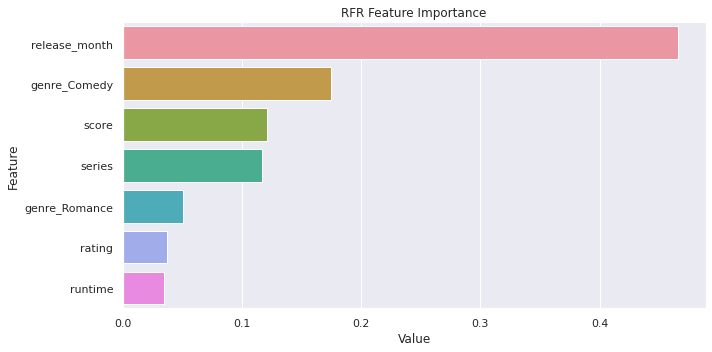

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(rf_final_wins.feature_importances_, X_train.columns),reverse = True), columns=['Value','Feature'])
feature_imp = feature_imp[feature_imp.Value != 0]
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('RFR Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
gridSearch.fit(X_train_sfm, y_train)
print('Best score:', gridSearch.best_score_)
print('Best parameters:', gridSearch.best_params_)

Best score: 0.5260854090879811
Best parameters: {'max_depth': 26, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0005, 'min_samples_leaf': 7, 'min_samples_split': 16, 'n_estimators': 500}


In [ ]:
rfrGCV_models_result = rfrmodelsummary('Baseline', X_train_sfm, X_test_sfm, y_train, y_test, gridSearch.best_estimator_) 
rfrGCV_models_result

,model,R2_train,R2_test,AdjR2_train,AdjR2_test,MSE_train,MSE_test,RMSE_train,RMSE_test
0,Baseline,0.664884,0.533927,0.664669,0.533226,12.703486,17.796069,3.564195,4.218539


=> TRY WITH LOG TRANSFORMED POPULARITY

In [ ]:
rfr = RandomForestRegressor(random_state=42, n_jobs=-1)

In [ ]:
def logrfrmodelsummary(name, X_train, X_test, y_train, y_test, model):
    
    model.fit(X_train, y_train)
    
    # training
    y_pred_train = model.predict(X_train)
    
    # training metrics
    mse_train = mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))
    mse_train_wo_exp = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    rsq_train = model.score(X_train, y_train)
    adjrsq_train = 1 - (((len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))*(1-rsq_train))
    
    # test
    y_pred_test = model.predict(X_test)
    
    # test metrics
    mse_test = mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test))
    mse_test_wo_exp = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    rsq_test = model.score(X_test, y_test)
    adjrsq_test = 1 - (((len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))*(1-rsq_test))
    
    df_model = pd.DataFrame({'model': [name],
                             'R2_train': [rsq_train], 'R2_test': [rsq_test],
                             'AdjR2_train': [adjrsq_train], 'AdjR2_test': [adjrsq_test], 
                             'MSE_train': [mse_train], 'MSE_test' : [mse_test],
                             'MSE_train_wo_exp': [mse_train_wo_exp], 'MSE_test_wo_exp' : [mse_test_wo_exp],
                             'RMSE_train': [rmse_train], 'RMSE_test' : [rmse_test]})   
    
    return df_model

In [ ]:
log_rfr_models_result = logrfrmodelsummary('Baseline', X_train_log, X_test_log, y_train_log, y_test_log, rfr)
log_rfr_models_result

,model,R2_train,R2_test,AdjR2_train,AdjR2_test,MSE_train,MSE_test,MSE_train_wo_exp,MSE_test_wo_exp,RMSE_train,RMSE_test
0,Baseline,0.953975,0.670112,0.953744,0.666231,42.454176,101.099799,0.032111,0.240028,6.515687,10.05484


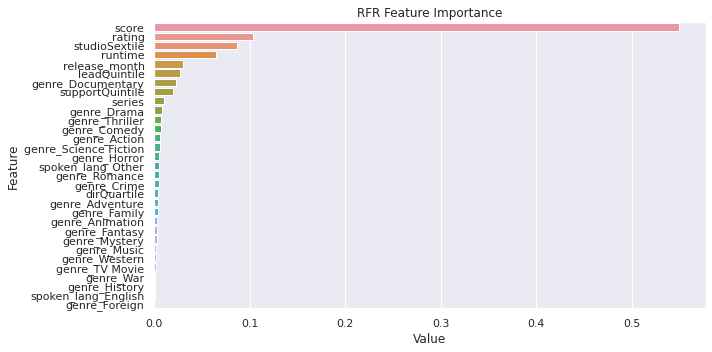

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(rfr.feature_importances_, X_train_log.columns),reverse = True), columns=['Value','Feature'])
feature_imp = feature_imp[feature_imp.Value != 0]
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('RFR Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
RFEselector = RFE(estimator=rfr, n_features_to_select=7, step=1)
RFEselector.fit(X_train_log, y_train_log)
X_train_log.columns[RFEselector.get_support()]

Index(['runtime', 'release_month', 'score', 'rating', 'leadQuintile',
       'supportQuintile', 'studioSextile'],
      dtype='object')

In [ ]:
RFEselector.ranking_

array([ 3,  1,  1,  1,  1, 11,  7, 25,  6, 15, 16, 20, 21, 19, 13, 12, 18,
       22,  2,  9,  8,  4, 17,  5, 23, 10, 24, 14,  1,  1,  1])

In [ ]:
X_train_log.columns

Index(['series', 'runtime', 'release_month', 'score', 'rating',
       'genre_Romance', 'genre_Comedy', 'genre_Foreign', 'genre_Action',
       'genre_Adventure', 'genre_Fantasy', 'genre_Western', 'genre_TV Movie',
       'genre_Music', 'genre_Crime', 'genre_Family', 'genre_Mystery',
       'genre_War', 'genre_Documentary', 'genre_Horror',
       'genre_Science Fiction', 'genre_Drama', 'genre_Animation',
       'genre_Thriller', 'genre_History', 'spoken_lang_Other',
       'spoken_lang_English', 'dirQuartile', 'leadQuintile', 'supportQuintile',
       'studioSextile'],
      dtype='object')

In [ ]:
X_train_rfe = RFEselector.transform(X_train_log)
X_test_rfe = RFEselector.transform(X_test_log)

In [ ]:
rfe_models_result = logrfrmodelsummary('Baseline', X_train_rfe, X_test_rfe, y_train_log, y_test_log, RFEselector)
rfe_models_result

,model,R2_train,R2_test,AdjR2_train,AdjR2_test,MSE_train,MSE_test,MSE_train_wo_exp,MSE_test_wo_exp,RMSE_train,RMSE_test
0,Baseline,0.949956,0.643284,0.949899,0.642345,44.292798,106.596613,0.034915,0.259549,6.655283,10.324564


In [ ]:
SFMselector = SelectFromModel(estimator=rfr)
SFMselector.fit(X_train_log, y_train_log)
X_train_log.columns[SFMselector.get_support()]

Index(['runtime', 'score', 'rating', 'studioSextile'], dtype='object')

In [ ]:
X_train_sfm = SFMselector.transform(X_train_log)
X_test_sfm = SFMselector.transform(X_test_log)

In [ ]:
sfm_models_result = logrfrmodelsummary('Baseline', X_train_sfm, X_test_sfm, y_train_log, y_test_log, rfr)
sfm_models_result

,model,R2_train,R2_test,AdjR2_train,AdjR2_test,MSE_train,MSE_test,MSE_train_wo_exp,MSE_test_wo_exp,RMSE_train,RMSE_test
0,Baseline,0.945682,0.614079,0.945647,0.6135,44.442945,104.157387,0.037897,0.280798,6.666554,10.205753


In [ ]:
# Info to help with tuning

print(rfr.estimators_[5].tree_.max_depth) # check how many nodes in the longest path
rfr.estimators_[5].tree_.n_node_samples # check how many samples in the last nodes

27


array([3991, 2847,  701, ...,    2,    1,    1], dtype=int64)

In [ ]:
# Extract data on single tree 

rfr_dict = {
    'id_node': list(range(rfr.estimators_[5].tree_.node_count)),
    'impurity': rfr.estimators_[5].tree_.impurity,
    'samples': rfr.estimators_[5].tree_.n_node_samples,
    'id_left_child': rfr.estimators_[5].tree_.children_left,
    'id_right_child': rfr.estimators_[5].tree_.children_right
}

impurity_df = pd.DataFrame(rfr_dict)
print(impurity_df.shape)
impurity_df.head(10)

(7975, 5)


,id_node,impurity,samples,id_left_child,id_right_child
0,0,0.690557,3991,1,5688
1,1,0.576079,2847,2,1403
2,2,0.314675,701,3,516
3,3,0.158610,257,4,233
4,4,0.086926,115,5,194
5,5,0.063712,95,6,23
6,6,0.034750,9,7,20
7,7,0.031366,7,8,9
8,8,0.000000,1,-1,-1
9,9,0.016561,6,10,17


In [ ]:
# Calculate min_impurity_decrease

impurity_df['impurity_decrease'] = np.nan
samples_total = rfr.estimators_[5].tree_.node_count

for idx in impurity_df.index[1:]:  # skip the first node, there aren't any splits prior to it
    if impurity_df.iloc[idx]['id_left_child'] == -1:
        continue  # we can't calculate impurity decrease for leaf nodes, as they no longer split
    else:
        impurity_P, samples_P = impurity_df.iloc[idx][['impurity', 'samples']]
        id_L, id_R = impurity_df.iloc[idx][['id_left_child', 'id_right_child']].astype(int)
        impurity_L, samples_L = impurity_df.iloc[id_L][['impurity', 'samples']]
        impurity_R, samples_R = impurity_df.iloc[id_R][['impurity', 'samples']]
        
        impurity_decrease = samples_P / samples_total * (
            impurity_P - samples_R / samples_P * impurity_R - 
            samples_L / samples_P * impurity_L
            )
        impurity_df.at[idx, 'impurity_decrease'] = impurity_decrease

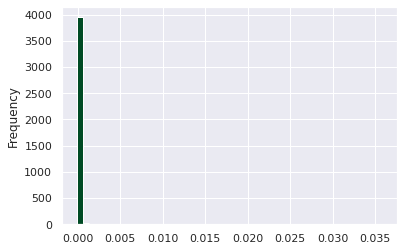

In [ ]:
impurity_df['impurity_decrease'].plot(kind='hist', bins=50)

In [ ]:
impurity_df['impurity_decrease'].describe() # 75% of values for impurity decrease lie below 0.000; use this as upper-bound for param

count    3.986000e+03
mean     6.149886e-05
std      6.908348e-04
min     -8.304285e-05
25%      5.385952e-07
50%      5.216919e-06
75%      2.904946e-05
max      3.570796e-02
Name: impurity_decrease, dtype: float64

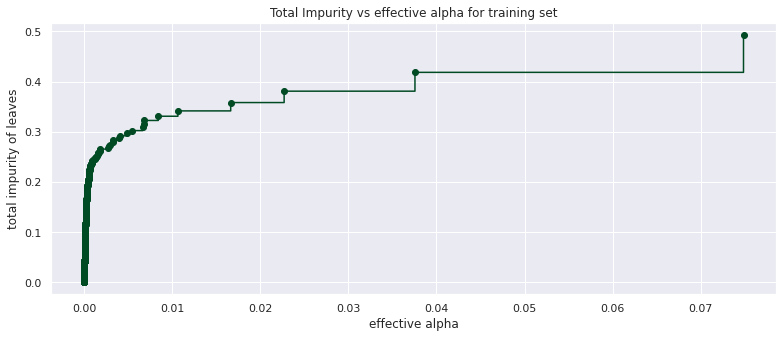

In [ ]:
# Figure out ccp_alphas

path = rfr.estimators_[5].cost_complexity_pruning_path(X_train_log, y_train_log)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(figsize=(13,5))
# the root node of the tree (indexed with [:-1]) is left out of the analysis, as without it there wouldn't be a tree
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")  
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [ ]:
# Tune parameters with random search

# param_distributions = {
#     'ccp_alpha': 0.0,
#     'max_depth': None,
#     'max_leaf_nodes': None,
#     'min_impurity_decrease': 0.0,
#     'min_impurity_split': None,
#     'min_samples_leaf': 1,
#     'min_samples_split': 2,
#     'min_weight_fraction_leaf': 0.0,
#     'max_features': 'auto'
# }

ccp_alpha = list(np.round(np.linspace(0,0.8,4), decimals=3))
max_depth = list(range(25,40,5))
max_leaf_nodes = [None] + list(range(2,20))
min_impurity_decrease = [0]
min_samples_leaf = [1,2,5,10,50] #list(range(1, 51, 10))
min_samples_split = [2,5,10,15,20,50,100] #list(range(10,100,10))
max_features = ['auto', 'sqrt']
n_estimators = [500]
        
param_distributions = {
    'ccp_alpha': ccp_alpha,
    'max_depth': max_depth,
    'max_leaf_nodes': max_leaf_nodes,
    'min_impurity_decrease': min_impurity_decrease,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'max_features': max_features,
    'n_estimators': n_estimators
}

tuning_options = len(ccp_alpha) * len(max_depth) * len(max_leaf_nodes) * len(min_impurity_decrease) * len(min_samples_leaf) * len(min_samples_split) * len(max_features) * len(n_estimators)
print(tuning_options)

15960


In [ ]:
randomSearch = RandomizedSearchCV(rfr, param_distributions, cv=5, n_jobs=-1, random_state=42, n_iter=100)

In [ ]:
randomSearch.fit(X_train_log, y_train_log)
print('Best score:', randomSearch.best_score_)
print('Best parameters:', randomSearch.best_params_)

Best score: 0.6195920238082481
Best parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0, 'max_leaf_nodes': 17, 'max_features': 'auto', 'max_depth': 30, 'ccp_alpha': 0.0}


In [ ]:
rfrRCV_models_result = logrfrmodelsummary('Baseline', X_train_log, X_test_log, y_train_log, y_test_log, randomSearch.best_estimator_)
rfrRCV_models_result

,model,R2_train,R2_test,AdjR2_train,AdjR2_test,MSE_train,MSE_test,MSE_train_wo_exp,MSE_test_wo_exp,RMSE_train,RMSE_test
0,Baseline,0.636905,0.62733,0.635087,0.622946,99.560586,107.835127,0.253324,0.271157,9.978005,10.384369


In [ ]:
randomSearch.fit(X_train_rfe, y_train_log)
print('Best score:', randomSearch.best_score_)
print('Best parameters:', randomSearch.best_params_)

Best score: 0.6115073707781278
Best parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0, 'max_leaf_nodes': 17, 'max_features': 'auto', 'max_depth': 30, 'ccp_alpha': 0.0}


In [ ]:
rfrRCV_models_result = logrfrmodelsummary('Baseline', X_train_rfe, X_test_rfe, y_train_log, y_test_log, randomSearch.best_estimator_)
rfrRCV_models_result

,model,R2_train,R2_test,AdjR2_train,AdjR2_test,MSE_train,MSE_test,MSE_train_wo_exp,MSE_test_wo_exp,RMSE_train,RMSE_test
0,Baseline,0.627798,0.618146,0.627379,0.617141,100.468518,109.053705,0.259678,0.277839,10.023399,10.442878


In [ ]:
randomSearch.fit(X_train_sfm, y_train_log)
print('Best score:', randomSearch.best_score_)
print('Best parameters:', randomSearch.best_params_)

Best score: 0.6037396455645883
Best parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0, 'max_leaf_nodes': 17, 'max_features': 'auto', 'max_depth': 30, 'ccp_alpha': 0.0}


In [ ]:
rfrRCV_models_result = logrfrmodelsummary('Baseline', X_train_sfm, X_test_sfm, y_train_log, y_test_log, randomSearch.best_estimator_)
rfrRCV_models_result

,model,R2_train,R2_test,AdjR2_train,AdjR2_test,MSE_train,MSE_test,MSE_train_wo_exp,MSE_test_wo_exp,RMSE_train,RMSE_test
0,Baseline,0.621236,0.612105,0.620992,0.611522,100.453487,109.033636,0.264256,0.282235,10.022649,10.441917


In [ ]:
# Fine tune parameters w/ grid search

max_depth = [28,29,30,31,32]
min_impurity_decrease = [0]
min_samples_split = [8,9,10,11,12]
max_features = ['auto']
min_samples_leaf = [2,3,4]
n_estimators = [500]

param_grid = {
    'max_depth': max_depth,
    'min_impurity_decrease': min_impurity_decrease,
    'min_samples_split': min_samples_split,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'n_estimators': n_estimators
}

tuning_options = len(max_depth) * len(min_impurity_decrease) * len(min_samples_split) * len(max_features) * len(min_samples_leaf) * len(n_estimators)
print(tuning_options)

75


In [ ]:
gridSearch = GridSearchCV(rfr, param_grid, cv=5, n_jobs=-1) 

In [ ]:
gridSearch.fit(X_train_log, y_train_log)
print('Best score:', gridSearch.best_score_)
print('Best parameters:', gridSearch.best_params_)

Best score: 0.677051482737059
Best parameters: {'max_depth': 28, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 500}


In [ ]:
rfrGCV_models_result = logrfrmodelsummary('Baseline', X_train_log, X_test_log, y_train_log, y_test_log, gridSearch.best_estimator_) 
rfrGCV_models_result
# final log

,model,R2_train,R2_test,AdjR2_train,AdjR2_test,MSE_train,MSE_test,MSE_train_wo_exp,MSE_test_wo_exp,RMSE_train,RMSE_test
0,Baseline,0.841879,0.682386,0.841088,0.678649,83.167104,100.201497,0.110318,0.231098,9.1196,10.01007


In [ ]:
rf_final_log = RandomForestRegressor(max_depth=28, max_features='auto', min_impurity_decrease=0, min_samples_leaf=4, min_samples_split=12, n_estimators=500, \
                                      random_state=42, n_jobs=-1)
rf_final_log.fit(X_train_log, y_train_log)

y_pred_rf_log = rf_final_log.predict(X_test_log)

r2_training = rf_final_log.score(X_train_log, y_train_log)
adj_r2_training = 1 - (1-r2_training)*(len(y_train_log)-1)/(len(y_train_log)-X_train_log.shape[1]-1)

r2_test = rf_final_log.score(X_test_log, y_test_log)
adj_r2_test = 1 - (1-r2_test)*(len(y_test_log)-1)/(len(y_test_log)-X_test_log.shape[1]-1)

print('training set: adjusted R2 score: %.4f' % adj_r2_training)
print('test set: adjusted R2 score: %.4f' % adj_r2_test)
print("training set: RMSE: %.4f" % np.sqrt(mean_squared_error(y_train_log, rf_final_log.predict(X_train_log))))
print("test set: RMSE: %.4f" % np.sqrt(mean_squared_error(y_test_log, y_pred_rf_log)))

training set: adjusted R2 score: 0.8411
test set: adjusted R2 score: 0.6786
training set: RMSE: 0.3321
test set: RMSE: 0.4807


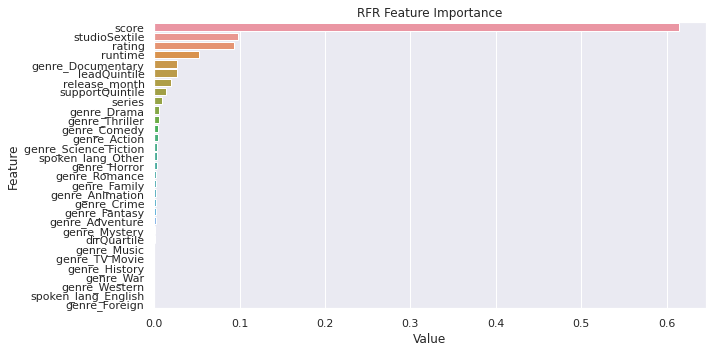

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(rf_final_log.feature_importances_, X_train_log.columns),reverse = True), columns=['Value','Feature'])
feature_imp = feature_imp[feature_imp.Value != 0]
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('RFR Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
gridSearch.fit(X_train_rfe, y_train_log)
print('Best score:', gridSearch.best_score_)
print('Best parameters:', gridSearch.best_params_)

Best score: 0.6553133455592076
Best parameters: {'max_depth': 28, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 500}


In [ ]:
rfrGCV_models_result = logrfrmodelsummary('Baseline', X_train_rfe, X_test_rfe, y_train_log, y_test_log, gridSearch.best_estimator_) 
rfrGCV_models_result

,model,R2_train,R2_test,AdjR2_train,AdjR2_test,MSE_train,MSE_test,MSE_train_wo_exp,MSE_test_wo_exp,RMSE_train,RMSE_test
0,Baseline,0.824707,0.658715,0.824509,0.657817,85.755083,103.968719,0.122299,0.248321,9.260404,10.196505


In [ ]:
gridSearch.fit(X_train_sfm, y_train_log)
print('Best score:', gridSearch.best_score_)
print('Best parameters:', gridSearch.best_params_)

Best score: 0.6312415751183365
Best parameters: {'max_depth': 31, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 500}


In [ ]:
rfrGCV_models_result = logrfrmodelsummary('Baseline', X_train_sfm, X_test_sfm, y_train_log, y_test_log, gridSearch.best_estimator_) 
rfrGCV_models_result

,model,R2_train,R2_test,AdjR2_train,AdjR2_test,MSE_train,MSE_test,MSE_train_wo_exp,MSE_test_wo_exp,RMSE_train,RMSE_test
0,Baseline,0.804563,0.636027,0.804437,0.63548,86.689902,103.484853,0.136353,0.264829,9.310741,10.172751


Note: Random forest regression code above also tested under following conditions - 

1.  Removed score and rating prior to calculating correlations because they were irrelevant or redundant with other variables

2. Smaller overall dataset (~5K total) with all missing values dropped and inclusion of isFemale_lead, isFemale_support, isFemale_director

## GradientBoostingRegressor

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor

### Select features - RFE
GB = GradientBoostingRegressor()
rfe = RFE(estimator=GB,  n_features_to_select=25)
fit = rfe.fit(X, y)
#print("Num Features: %s" % (fit.n_features_))
#print("Selected Features: %s" % (fit.support_))
#print("Feature Ranking: %s" % (fit.ranking_))
#print(X.columns)

selected_feature_RFE = []
for x,y in zip(fit.ranking_,X.columns):
    if x == 1:
        selected_feature_RFE.append(y)
selected_feature_RFE

In [ ]:
### Select features - VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

vif_data = vif_data.sort_values(by = 'VIF',ascending=True)
vif_data
selected_feature_VIF = vif_data.feature[:25]

In [ ]:
#GradientBoostingRegressor
#Check the model fitness before tuning hyperparameter
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

GBR = GradientBoostingRegressor()
GBR.fit(X_train_GB, y_train_GB)
y_pred_GB = GBR.predict(X_test_GB)

r2_training = GBR.score(X_train_GB, y_train_GB)
adj_r2_training = 1 - (1-r2_training)*(len(y_train_GB)-1)/(len(y_train_GB)-X_train_GB.shape[1]-1)

r2_test = GBR.score(X_test_GB, y_test_GB)
adj_r2_test = 1 - (1-r2_test)*(len(y_test_GB)-1)/(len(y_test_GB)-X_test_GB.shape[1]-1)

print('training set: adjusted R2 score: %.4f' % adj_r2_training)
print('test set: adjusted R2 score: %.4f' % adj_r2_test)
print("training set: RMSE: %.4f" % np.sqrt(mean_squared_error(y_train_GB, GBR.predict(X_train_GB))))
print("test set: RMSE: %.4f" % np.sqrt(mean_squared_error(y_test_GB, y_pred_GB)))

training set: adjusted R2 score: 0.7159
test set: adjusted R2 score: 0.6708
training set: RMSE: 3.3699
test set: RMSE: 3.2717


In [ ]:
X_train_GB.columns

Index(['series', 'runtime', 'score', 'rating', 'genre_Romance', 'genre_Comedy',
       'genre_Foreign', 'genre_Action', 'genre_Adventure', 'genre_Fantasy',
       'genre_Western', 'genre_TV Movie', 'genre_Music', 'genre_Crime',
       'genre_Family', 'genre_Mystery', 'genre_War', 'genre_Documentary',
       'genre_Horror', 'genre_Science Fiction', 'genre_Drama',
       'genre_Animation', 'genre_Thriller', 'genre_History',
       'spoken_lang_Other', 'spoken_lang_English', 'dirQuartile',
       'leadQuintile', 'supportQuintile', 'studioSextile',
       'time_since_released'],
      dtype='object')

In [ ]:
param_test1 = {'n_estimators': [590,610,630,670,720,750],'learning_rate': [0.01,0.02]}

In [ ]:
#from sklearn.model_selection import GridSearchCV
GBR = GradientBoostingRegressor(max_depth=6, subsample=0.5,random_state = 1) #starting values
grid_GBR = GridSearchCV(estimator=GBR, param_grid = param_test1, cv = 3, n_jobs=-1)
grid_GBR.fit(X_train_GB, y_train_GB)
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)


 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.01, max_depth=6, n_estimators=610,
                          random_state=1, subsample=0.5)

 The best score across ALL searched params:
 0.6239617537253325


In [ ]:
param_test2 = {'min_samples_split':range(5,20), 'min_samples_leaf':range(2,20,5)}

In [ ]:
GBR2 = GradientBoostingRegressor(max_depth=6, subsample=0.5,learning_rate=0.01,n_estimators=610)
grid_GBR2 = GridSearchCV(estimator=GBR2, param_grid = param_test2, cv = 3, n_jobs=-1)
grid_GBR2.fit(X_train_GB, y_train_GB)
print("\n The best estimator across ALL searched params:\n",grid_GBR2.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR2.best_score_)


 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.01, max_depth=6, min_samples_leaf=17,
                          min_samples_split=10, n_estimators=610,
                          subsample=0.5)

 The best score across ALL searched params:
 0.6294403956048048


In [ ]:
param_test3 = {'max_depth':[6,8,12,20,25],'subsample': [0.9, 0.5, 0.4, 0.3]}

In [ ]:
GBR3 = GradientBoostingRegressor(learning_rate=0.01,n_estimators=610,min_samples_split=10,\
                                min_samples_leaf = 17)
grid_GBR3 = GridSearchCV(estimator=GBR3, param_grid = param_test3, cv = 3, n_jobs=-1)
grid_GBR3.fit(X_train_GB, y_train_GB)
print("\n The best estimator across ALL searched params:\n",grid_GBR3.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR3.best_score_)


 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.01, max_depth=6, min_samples_leaf=17,
                          min_samples_split=10, n_estimators=610,
                          subsample=0.5)

 The best score across ALL searched params:
 0.6279983898523144


In [ ]:
# Final Test
import math
from sklearn.metrics import r2_score, mean_squared_error

GBR_4 = GradientBoostingRegressor(learning_rate=0.01, max_depth=6, min_samples_leaf=17,
                          min_samples_split=10, n_estimators=610,
                          subsample=0.5,loss = 'squared_error')
GBR_4.fit(X_train_GB, y_train_GB)
y_pred = GBR_4.predict(X_test_GB)

r2_training = GBR_4.score(X_train_GB, y_train_GB)
adj_r2_training = 1 - (1-r2_training)*(len(y_train_GB)-1)/(len(y_train_GB)-X_train_GB.shape[1]-1)

r2_test = GBR_4.score(X_test_GB, y_test_GB)
adj_r2_test = 1 - (1-r2_test)*(len(y_test_GB)-1)/(len(y_test_GB)-X_test_GB.shape[1]-1)

print('training set: adjusted R2 score: %.4f' % adj_r2_training)
print('test set: adjusted R2 score: %.4f' % adj_r2_test)
print("training set: RMSE: %.4f" % np.sqrt(mean_squared_error(y_train_GB, GBR_4.predict(X_train_GB))))
print("test set: RMSE: %.4f" % np.sqrt(mean_squared_error(y_test_GB, y_pred)))

training set: adjusted R2 score: 0.7371
test set: adjusted R2 score: 0.6709
training set: RMSE: 3.2418
test set: RMSE: 3.2710


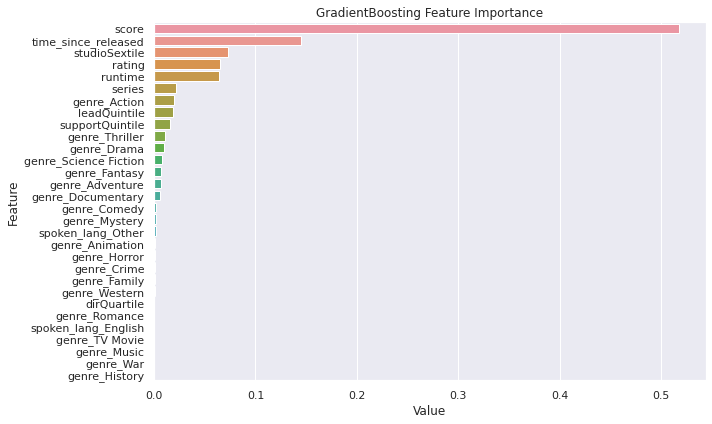

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(GBR_4.feature_importances_, X_train_GB.columns),reverse = True), columns=['Value','Feature'])
feature_imp = feature_imp[feature_imp.Value != 0]
plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('GradientBoosting Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
param_test1 = {'n_estimators': [550,650,700,750,800],'learning_rate': [0.01,0.02]}

GBR = GradientBoostingRegressor(max_depth=6, subsample=0.5,random_state = 1)
grid_GBR = GridSearchCV(estimator=GBR, param_grid = param_test1, cv = 2, n_jobs=-1)
grid_GBR.fit(X_train_log, y_train_log)
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)


 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.01, max_depth=6, n_estimators=650,
                          random_state=1, subsample=0.5)

 The best score across ALL searched params:
 0.7046564200359934


In [ ]:
param_test2 = {'min_samples_split':range(10,20), 'min_samples_leaf':range(2,20,5)}
GBR2 = GradientBoostingRegressor(max_depth=6, subsample=0.5,learning_rate=0.01,n_estimators=650)
grid_GBR2 = GridSearchCV(estimator=GBR2, param_grid = param_test2, cv = 2, n_jobs=-1)
grid_GBR2.fit(X_train_log, y_train_log)
print("\n The best estimator across ALL searched params:\n",grid_GBR2.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR2.best_score_)


 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.01, max_depth=6, min_samples_leaf=7,
                          min_samples_split=14, n_estimators=650,
                          subsample=0.5)

 The best score across ALL searched params:
 0.7064196608606461


In [ ]:
param_test3 = {'max_depth':[3,4,5,6,8,12],'subsample': [0.9, 0.5, 0.4, 0.3]}
GBR3 = GradientBoostingRegressor(learning_rate=0.01,n_estimators=650,min_samples_split=7,\
                                min_samples_leaf = 14)
grid_GBR3 = GridSearchCV(estimator=GBR3, param_grid = param_test3, cv = 2, n_jobs=-1)
grid_GBR3.fit(X_train_log, y_train_log)
print("\n The best estimator across ALL searched params:\n",grid_GBR3.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR3.best_score_)


 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.01, max_depth=6, min_samples_leaf=14,
                          min_samples_split=7, n_estimators=650, subsample=0.5)

 The best score across ALL searched params:
 0.7052773841994122


In [ ]:
GBR_log = GradientBoostingRegressor(learning_rate=0.01, max_depth=6, min_samples_leaf=14,
                          min_samples_split=7, n_estimators=650, subsample=0.5,loss = 'squared_error')
GBR_log.fit(X_train_log, y_train_log)
y_pred_log = GBR_log.predict(X_test_log)

r2_training = GBR_log.score(X_train_log, y_train_log)
adj_r2_training = 1 - (1-r2_training)*(len(y_train_log)-1)/(len(y_train_log)-X_train_log.shape[1]-1)

r2_test = GBR_log.score(X_test_log, y_test_log)
adj_r2_test = 1 - (1-r2_test)*(len(y_test_log)-1)/(len(y_test_log)-X_test_log.shape[1]-1)

print('training set: adjusted R2 score: %.4f' % adj_r2_training)
print('test set: adjusted R2 score: %.4f' % adj_r2_test)
print("training set RMSE(back transformed): %.4f" % np.sqrt(mean_squared_error(np.expm1(y_train_log), np.expm1(GBR_log.predict(X_train_log)))))
print("test set RMSE(back transformed): %.4f" % np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_log))))

training set: adjusted R2 score: 0.7946
test set: adjusted R2 score: 0.7216
training set RMSE(back transformed): 8.7172
test set RMSE(back transformed): 9.1925


In [ ]:
print("training set RMSE: %.4f" % np.sqrt(mean_squared_error(y_train_log, GBR_log.predict(X_train_log))))
print("test set RMSE: %.4f" % np.sqrt(mean_squared_error(y_test_log, y_pred_log)))

training set RMSE: 0.3776
test set RMSE: 0.4473


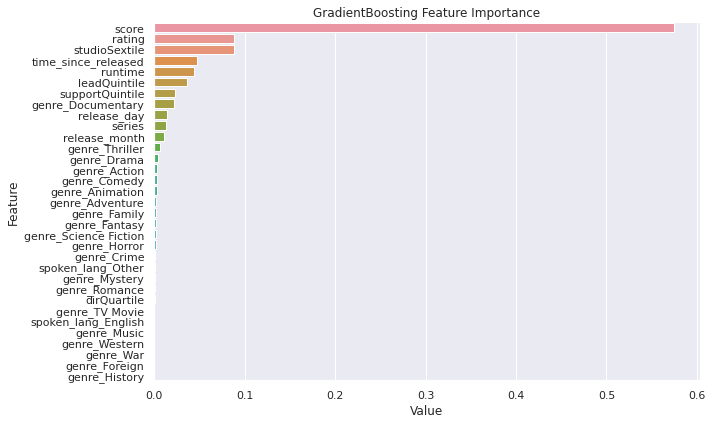

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(GBR_log.feature_importances_, X_train_log.columns),reverse = True), columns=['Value','Feature'])
feature_imp = feature_imp[feature_imp.Value != 0]
plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('GradientBoosting Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
y_pred_gbm_train = GBR_4.predict(X_train)
y_pred_xgbr_train = np.expm1(xgbr_log.predict(X_train))

y_pred_avg_train = (y_pred_gbm_train + y_pred_xgbr_train)/2
np.sqrt(mean_squared_error(y_train, y_pred_avg_train))

3.6613620324590572

In [ ]:
y_pred_gbm = y_pred
y_pred_xgbr = np.expm1(y_pred_log)

y_pred_avg = (y_pred_gbm + y_pred_xgbr)/2
np.sqrt(mean_squared_error(y_test, y_pred_avg))

5.227136818435236